# This notebook contains all the codes we need for the dissertation

### Input Packages

In [2]:
# clr should be installed, sample code to build and run a ESG simulation using pythonnet. http://pythonnet.github.io/
import clr
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import linalg as LA
import matplotlib.ticker as ticker
import matplotlib

# Here the Regex has been used to search up the letter or the word that we want in the context.
import re

from mpl_toolkits import mplot3d
import matplotlib.tri as mtri
import itertools
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.font_manager as font_manager
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# Importing the linear regression model from sklearn:
from sklearn.linear_model import LinearRegression

from matplotlib.ticker import (AutoLocator, AutoMinorLocator)

### Making up the Control parameter function
In the function, it should include
* getting parameter's vlaue and sort out the format
* checking up the unique vlaue of each parameter
* adding output file and adding particular output to the file, then do the calibration
* choosing randomly the values of the parameter(for making up the combination of the parameter set)
* control each of the parameter and fix others to see how does output change if we only change the controled parameter

For the output we get at the end, we will use another function to sort out the format later.

In [3]:
# maturities2 = np.arange(0.0834,1,4583/80000)
# np.concatenate((np.arange(0.25,1,0.25),np.arange(1,10,1),np.arange(10,30,5)))
# 'two inputs of maturities we use'

def ControlParameter_version2(control="Correlation", ScaleStress=0.01, ValueFix="Median", maturities = None):
    
    '''
    The function is used to generate the calibrated implied volatilities under multi-maturities and multi-strikes. 
    The whole processes have been done by using Moody's ESG with some side calibration(.bhc) and simulation(.bhs) files.
    The function will help us to generate three excel files for each parameter, which we fit Max, Median, and Min values 
    of the parameter and fit values of other parameters to be the Median value. The IV target sets we get from the ESG 
    are for derivatives with multi-maturities and multi-strikes. Each simulation should be done individually from the very
    beginning, otherwise the simulation output files will overlap.
    
    Inputs:
        control: str, default 'Correlation'
            the parameter that we decide to fit with different values, and fix others with Median value.
    
        ScaleStress: int, default '0.01'
            the scaled values of the max and min for each parameter.
            
        ValueFix: str, default 'Median'
            the parameter that we want to fix from the range of the parameter vlaue table
            
        maturities: list
            this parameter should be a list with size 16 which indicates the range of maturities that we want to price
        
    
    Outputs: excel file
            the generated data will be sorted out into three different excel files with name Max..., Median..., and Min... .
    '''
    
    # clr should be installed, sample code to build and run a ESG simulation using pythonnet. http://pythonnet.github.io/
    # system setting, connect to the ESG
    assembly_path = r"C:\Program Files\Moody's Analytics\SG\9.8.0"
    sys.path.append(assembly_path)
    clr.AddReference("BarrHibb.Sim.API")
    from BarrHibb.Sim.API import Simulation
    
    # Activate the simulation file
    simulation = Simulation()
    
    # get the excel file for the range parameter's values (user specific)
    df = pd.read_excel(r'C:\Users\Roger Cai\OneDrive\Desktop\Moodys_project\Parameter_range.xlsx')
    df = pd.DataFrame(df)

    # preparing the input parameter's values
    ParaName = ["ArrivalRate", "JumpMean", "JumpVolatility", "Correlation", "MeanReversionLevel", "MeanReversionRate", "InitialValue", "Volatility"]
    df.iloc[:8, 0] = ParaName
    df = df.set_index('Unnamed: 0')
    df.index.name = 'ParentEquityModel'
    df_ = df.iloc[:, 0:3]
    df_.loc[:, "Max"] = df_.loc[:, "Median"].copy() + ScaleStress
    df_.loc[:, "Min"] = df_.loc[:, "Median"].copy() - ScaleStress
    
    # Fix globally the values of the parameters that we want to input into the model
    Choice_dic = {'ArrivalRate' : df_.loc["ArrivalRate", ValueFix]
                   , 'JumpMean' : df_.loc["JumpMean", ValueFix]
                   , 'JumpVolatility' : df_.loc["JumpVolatility", ValueFix]
                   , 'Correlation' : df_.loc["Correlation", ValueFix]
                   , 'MeanReversionLevel' : df_.loc["MeanReversionLevel", ValueFix]
                   , 'MeanReversionRate' : df_.loc["MeanReversionRate", ValueFix]
                   , 'InitialValue' : df_.loc["InitialValue", ValueFix]
                   , 'Volatility' : df_.loc["Volatility", ValueFix]}
    
    # ****** These paths are user specific *******
    dataPath = (r"C:\Users\<user>\AppData\Local\Moody's_Analytics,_Inc\BarrHibb.Sim.UI.exe_StrongName_e1wsydkdo5eocko4vyo3jjpaaqod4bxp\9.8.0.0")
    modelPath = r"C:\Program Files\Moody's Analytics\SG\9.8.0\Models"
    outputPath = r"C:\Users\Roger Cai\OneDrive\Desktop\output of My Simulations\SecondPartOfTheResult"
    licencePath = r"C:\Users\Roger Cai\OneDrive\Desktop\Moodys_project\Training-Moodys Analytics Research Group-120522-010922.lic"
    sim_file = r"C:\Users\Roger Cai\OneDrive\Desktop\Moodys_project\Simulation_File\SampleScriptSim.bhs"
    CalibrateFilePath = r"C:\Users\Roger Cai\OneDrive\Desktop\Moodys_project\EndJun2021_MC_SWAP_Global_Standard_SVJD.bhc"
    # **************************************************
    
    # Activate the licence of running Moody's confidential ESG
    simulation.InitialiseWithLicence(modelPath, '', dataPath, licencePath)

    # Setting up the environment in ESG, the method that we use, model type, sample size, and time step 
    simulation.Create("ESG")
    economy = simulation.AddModelWithName('Economy', "GBP")
    nycs = economy.SubModel("NominalYieldCurves")
    nyc = nycs.SubModel("NominalYieldCurve")
    nyc.Type = "AnnualLMMPlus"
    PEAC = simulation.AddModelWithName("ParentEquityAssetCorrelationModel", "E_GBP")
    PEAC.Parameter('Economy').Value = economy.Name
    Sigma = PEAC.SubModel("Sigma")
    Sigma.Type = "SVJD"
    Jump = Sigma.SubModel("Jump")
    Variance = Sigma.SubModel("Variance")
    simulation.Parameter('BaseEconomy').Value = economy.Name
    simulation.Parameter('BaseDate').Value='16/08/2022'
    simulation.Parameter('NumberOfTrials').Value = 1
    timeSteps = simulation.ParameterCollection("Timesteps")
    # timestep 52 means, hedging once every year, continue hedging 52 years
    timeSteps["Annual"] = 52
    simulation.Parameter("RandomNumberGenerator").Value = 'MersenneTwister'
    simulation.Parameter("UseAntithetics").Value = False
    simulation.Parameter("UseRiskNeutralValuation").Value = True
    simulation.Parameter("EquityAssetCorrelationMethod").Value = "CorrelationMatrix"
    
    if control == "Correlation":
        
        # The name list of the columns in the output excel file
        selectedOutputNames = []
        
        # Add output
        outputFile = simulation.AddOutputFile('RNAP_new')
        outputFile.Folder = outputPath
        
        # Fix the range of the maturities and strikes that we want to price
        forwardStrike = PEAC.Output("EquityOptionImpliedVolatility")
        Parameters_ = forwardStrike.Parameters
        Parameters_[1].Value = "ForwardStrike2"
        strikes = np.arange(0.5,1.6,0.1)
        maturities = maturities
        for i in strikes:
            for j in maturities:    
                Parameters_[0].Value = float(j)
                Parameters_[2].Value = float(i)
                selectedOutput_ = outputFile.AddOutputWithParameters(forwardStrike, Parameters_)[0]
                selectedOutputNames.append(selectedOutput_.FullName)

        # Calibration(.bhc)
        simulation.Calibrate(CalibrateFilePath)
        
        # Save the simulation file(.bhs)
        simulation.Save(sim_file)

        # Set up the parameter's values that we want to control
        Correlation_value = [df.loc["Correlation", "Max"], df.loc["Correlation", "Median"], df.loc["Correlation", "Min"]]
        
        # Iterating through and do the simulation for each pair of maturity and strike
        for idx, i in enumerate(Correlation_value):
            for name in Choice_dic.keys():
                if name in ["ArrivalRate", "JumpMean", "JumpVolatility"]:
                    Jump.Parameter(name).Value = float(Choice_dic[name])
                elif name == "Correlation":
                    Variance.Parameter(name).Value = float(i)
                elif name in ["MeanReversionLevel","MeanReversionRate","InitialValue","Volatility"]:
                    Variance.Parameter(name).Value = float(Choice_dic[name])
                    
            # Set the name of the output file        
            name = ["Max", "Median", "Min"]
            outputFile.Name = 'RNAP_Correlation_'+str(name[idx])

            # Save simulation file:
            simulation.Save(sim_file[0:-4]+'_'+'Correlation'+str(i)+'.bhs')
            simulation.RunLocally(0, True)
            
    elif control == "ArrivalRate":

        # The name list of the columns in the output excel file
        selectedOutputNames = []

        # Add output
        outputFile = simulation.AddOutputFile('RNAP_new')
        outputFile.Folder = outputPath

        # Fix the range of the maturities and strikes that we want to price
        forwardStrike = PEAC.Output("EquityOptionImpliedVolatility")
        Parameters_ = forwardStrike.Parameters
        Parameters_[1].Value = "ForwardStrike2"
        strikes = np.arange(0.5,1.6,0.1)
        maturities = maturities
        for i in strikes:
            for j in maturities:    
                Parameters_[0].Value = float(j)
                Parameters_[2].Value = float(i)
                selectedOutput_ = outputFile.AddOutputWithParameters(forwardStrike, Parameters_)[0]
                selectedOutputNames.append(selectedOutput_.FullName)

        # Calibration(.bhc)
        simulation.Calibrate(CalibrateFilePath)
        
        # Save the simulation file(.bhs)
        simulation.Save(sim_file)

        # Set up the parameter's values that we want to control
        ArrivalRate_value = [df.loc["ArrivalRate", "Max"], df.loc["ArrivalRate", "Median"], df.loc["ArrivalRate", "Min"]]

        # Iterating through and do the simulation for each pair of maturity and strike
        for idx, i in enumerate(ArrivalRate_value):
            for name in Choice_dic.keys():
                if name in ["JumpMean", "JumpVolatility"]:
                    Jump.Parameter(name).Value = float(Choice_dic[name])
                elif name == "ArrivalRate":
                    Jump.Parameter(name).Value = float(i)
                elif name in ["Correlation", "MeanReversionLevel","MeanReversionRate","InitialValue","Volatility"]:
                    Variance.Parameter(name).Value = float(Choice_dic[name])

            # Set the name of the output file   
            name = ["Max", "Median", "Min"]
            outputFile.Name = 'RNAP_ArrivalRate_'+str(name[idx])

            # Save simulation file:
            simulation.Save(sim_file[0:-4]+'_'+'ArrivalRate'+str(i)+'.bhs')
            simulation.RunLocally(0, True)
    
    elif control == "JumpMean":

        # The name list of the columns in the output excel file
        selectedOutputNames = []

        # Add output
        outputFile = simulation.AddOutputFile('RNAP_new')
        outputFile.Folder = outputPath

        # Fix the range of the maturities and strikes that we want to price
        forwardStrike = PEAC.Output("EquityOptionImpliedVolatility")
        Parameters_ = forwardStrike.Parameters
        Parameters_[1].Value = "ForwardStrike2"
        strikes = np.arange(0.5,1.6,0.1)
        maturities = maturities
        for i in strikes:
            for j in maturities:    
                Parameters_[0].Value = float(j)
                Parameters_[2].Value = float(i)
                selectedOutput_ = outputFile.AddOutputWithParameters(forwardStrike, Parameters_)[0]
                selectedOutputNames.append(selectedOutput_.FullName)

        # Calibration(.bhc)
        simulation.Calibrate(CalibrateFilePath)
        
        # Save the simulation file(.bhs)
        simulation.Save(sim_file)
        
        # Set up the parameter's values that we want to control
        JumpMean_value = [df.loc["JumpMean", "Max"], df.loc["JumpMean", "Median"], df.loc["JumpMean", "Min"]]

        # Iterating through and do the simulation for each pair of maturity and strike
        for idx, i in enumerate(JumpMean_value):
            for name in Choice_dic.keys():
                if name in ["ArrivalRate", "JumpVolatility"]:
                    Jump.Parameter(name).Value = float(Choice_dic[name])
                elif name == "JumpMean":
                    Jump.Parameter(name).Value = float(i)
                elif name in ["Correlation", "MeanReversionLevel","MeanReversionRate","InitialValue","Volatility"]:
                    Variance.Parameter(name).Value = float(Choice_dic[name])

            # Set the name of the output file   
            name = ["Max", "Median", "Min"]
            outputFile.Name = 'RNAP_JumpMean_'+str(name[idx])

            # Save simulation file:
            simulation.Save(sim_file[0:-4]+'_'+'JumpMean'+str(i)+'.bhs')
            simulation.RunLocally(0, True)
    
    # Following comments are the same as above
    
    elif control == "JumpVolatility":
        
        selectedOutputNames = []
        
        # Add output
        outputFile = simulation.AddOutputFile('RNAP_new')
        outputFile.Folder = outputPath

        forwardStrike = PEAC.Output("EquityOptionImpliedVolatility")
        Parameters_ = forwardStrike.Parameters
        Parameters_[1].Value = "ForwardStrike2"
        strikes = np.arange(0.5,1.6,0.1)
        maturities = maturities
        for i in strikes:
            for j in maturities:    
                Parameters_[0].Value = float(j)
                Parameters_[2].Value = float(i)
                selectedOutput_ = outputFile.AddOutputWithParameters(forwardStrike, Parameters_)[0]
                selectedOutputNames.append(selectedOutput_.FullName)

        # Calibration
        simulation.Calibrate(CalibrateFilePath)
        
        simulation.Save(sim_file)
        
        JumpVolatility_value = [df.loc["JumpVolatility", "Max"], df.loc["JumpVolatility", "Median"], df.loc["JumpVolatility", "Min"]]

        for idx, i in enumerate(JumpVolatility_value):
            for name in Choice_dic.keys():
                if name in ["ArrivalRate", "JumpMean"]:
                    Jump.Parameter(name).Value = float(Choice_dic[name])
                elif name == "JumpVolatility":
                    Jump.Parameter(name).Value = float(i)
                elif name in ["Correlation", "MeanReversionLevel","MeanReversionRate","InitialValue","Volatility"]:
                    Variance.Parameter(name).Value = float(Choice_dic[name])

            name = ["Max", "Median", "Min"]
            outputFile.Name = 'RNAP_JumpVolatility_'+str(name[idx])

            # Save simulation file:
            simulation.Save(sim_file[0:-4]+'_'+'JumpVolatility'+str(i)+'.bhs')
            simulation.RunLocally(0, True)
    
    elif control == "MeanReversionLevel":
        
        selectedOutputNames = []

        # Add output
        outputFile = simulation.AddOutputFile('RNAP_new')
        outputFile.Folder = outputPath

        forwardStrike = PEAC.Output("EquityOptionImpliedVolatility")
        Parameters_ = forwardStrike.Parameters
        Parameters_[1].Value = "ForwardStrike2"
        strikes = np.arange(0.5,1.6,0.1)
        maturities = maturities
        for i in strikes:
            for j in maturities:    
                Parameters_[0].Value = float(j)
                Parameters_[2].Value = float(i)
                selectedOutput_ = outputFile.AddOutputWithParameters(forwardStrike, Parameters_)[0]
                selectedOutputNames.append(selectedOutput_.FullName)

        # Calibration
        simulation.Calibrate(CalibrateFilePath)
        simulation.Save(sim_file)
        
        MeanReversionLevel_value = [df.loc["MeanReversionLevel", "Max"], df.loc["MeanReversionLevel", "Median"], df.loc["MeanReversionLevel", "Min"]]

        for idx, i in enumerate(MeanReversionLevel_value):
            for name in Choice_dic.keys():
                if name in ["ArrivalRate", "JumpMean", "JumpVolatility"]:
                    Jump.Parameter(name).Value = float(Choice_dic[name])
                elif name in ["Correlation","MeanReversionRate","InitialValue","Volatility"]:
                    Variance.Parameter(name).Value = float(Choice_dic[name])
                elif name == "MeanReversionLevel":
                    Variance.Parameter(name).Value = float(i)
                
            name = ["Max", "Median", "Min"]
            outputFile.Name = 'RNAP_MeanReversionLevel_'+str(name[idx])

            # Save simulation file:
            simulation.Save(sim_file[0:-4]+'_'+'MeanReversionLevel'+str(i)+'.bhs')
            simulation.RunLocally(0, True)
    
    elif control == "MeanReversionRate":

        selectedOutputNames = []

        # Add output
        outputFile = simulation.AddOutputFile('RNAP_new')
        outputFile.Folder = outputPath

        forwardStrike = PEAC.Output("EquityOptionImpliedVolatility")
        Parameters_ = forwardStrike.Parameters
        Parameters_[1].Value = "ForwardStrike2"
        strikes = np.arange(0.5,1.6,0.1)
        maturities = maturities
        for i in strikes:
            for j in maturities:    
                Parameters_[0].Value = float(j)
                Parameters_[2].Value = float(i)
                selectedOutput_ = outputFile.AddOutputWithParameters(forwardStrike, Parameters_)[0]
                selectedOutputNames.append(selectedOutput_.FullName)

        # Calibration
        simulation.Calibrate(CalibrateFilePath)
        simulation.Save(sim_file)
        
        MeanReversionRate_value = [df.loc["MeanReversionRate", "Max"], df.loc["MeanReversionRate", "Median"], df.loc["MeanReversionRate", "Min"]]
    
        for idx, i in enumerate(MeanReversionRate_value):
            for name in Choice_dic.keys():
                if name in ["ArrivalRate", "JumpMean", "JumpVolatility"]:
                    Jump.Parameter(name).Value = float(Choice_dic[name])
                elif name in ["Correlation","MeanReversionLevel","InitialValue","Volatility"]:
                    Variance.Parameter(name).Value = float(Choice_dic[name])
                elif name == "MeanReversionRate":
                    Variance.Parameter(name).Value = float(i)

            name = ["Max", "Median", "Min"]
            outputFile.Name = 'RNAP_MeanReversionRate_'+str(name[idx])

            # Save simulation file:
            simulation.Save(sim_file[0:-4]+'_'+'MeanReversionRate'+str(i)+'.bhs')
            simulation.RunLocally(0, True)
        
    elif control == "InitialValue":

        selectedOutputNames = []

        # Add output
        outputFile = simulation.AddOutputFile('RNAP_new')
        outputFile.Folder = outputPath

        forwardStrike = PEAC.Output("EquityOptionImpliedVolatility")
        Parameters_ = forwardStrike.Parameters
        Parameters_[1].Value = "ForwardStrike2"
        strikes = np.arange(0.5,1.6,0.1)
        maturities = maturities
        for i in strikes:
            for j in maturities:    
                Parameters_[0].Value = float(j)
                Parameters_[2].Value = float(i)
                selectedOutput_ = outputFile.AddOutputWithParameters(forwardStrike, Parameters_)[0]
                selectedOutputNames.append(selectedOutput_.FullName)

        # Calibration
        simulation.Calibrate(CalibrateFilePath)
        simulation.Save(sim_file)
        
        InitialValue_value = [df.loc["InitialValue", "Max"], df.loc["InitialValue", "Median"], df.loc["InitialValue", "Min"]]

        for idx, i in enumerate(InitialValue_value):
            for name in Choice_dic.keys():
                if name in ["ArrivalRate", "JumpMean", "JumpVolatility"]:
                    Jump.Parameter(name).Value = float(Choice_dic[name])
                elif name in ["Correlation","MeanReversionLevel","MeanReversionRate","Volatility"]:
                    Variance.Parameter(name).Value = float(Choice_dic[name])
                elif name == "InitialValue":
                    Variance.Parameter(name).Value = float(i)

            name = ["Max", "Median", "Min"]
            outputFile.Name = 'RNAP_InitialValue_'+str(name[idx])

            # Save simulation file:
            simulation.Save(sim_file[0:-4]+'_'+'InitialValue'+str(i)+'.bhs')
            simulation.RunLocally(0, True)
        
    elif control == "Volatility":

        selectedOutputNames = []

        # Add output
        outputFile = simulation.AddOutputFile('RNAP_new')
        outputFile.Folder = outputPath

        forwardStrike = PEAC.Output("EquityOptionImpliedVolatility")
        Parameters_ = forwardStrike.Parameters
        Parameters_[1].Value = "ForwardStrike2"
        strikes = np.arange(0.5,1.6,0.1)
        maturities = maturities
        for i in strikes:
            for j in maturities:    
                Parameters_[0].Value = float(j)
                Parameters_[2].Value = float(i)
                selectedOutput_ = outputFile.AddOutputWithParameters(forwardStrike, Parameters_)[0]
                selectedOutputNames.append(selectedOutput_.FullName)

        # Calibration
        simulation.Calibrate(CalibrateFilePath)
        simulation.Save(sim_file)
        
        InitialValue_value = [df.loc["Volatility", "Max"], df.loc["Volatility", "Median"], df.loc["Volatility", "Min"]]

        for idx, i in enumerate(InitialValue_value):
            for name in Choice_dic.keys():
                if name in ["ArrivalRate", "JumpMean", "JumpVolatility"]:
                    Jump.Parameter(name).Value = float(Choice_dic[name])
                elif name in ["Correlation","MeanReversionLevel","MeanReversionRate","InitialValue"]:
                    Variance.Parameter(name).Value = float(Choice_dic[name])
                elif name == "Volatility":
                    Variance.Parameter(name).Value = float(i)

            name = ["Max", "Median", "Min"]
            outputFile.Name = 'RNAP_Volatility_'+str(name[idx])

            # Save simulation file:
            simulation.Save(sim_file[0:-4]+'_'+'Volatility'+str(i)+'.bhs')
            simulation.RunLocally(0, True)
              

### Function for sorting out the output from previous function:
* read output file
* regex(searching for the number that we need for the making up the output matrix)
* transpose the matrix to get ready for making the pivot table
* add the sorted maturity and strike to be the new columns
* making up the pivot table
* stack matrice all together and change the shape. 
#### Purpose is to help out the next function! Let's incorperate!

In [4]:
def SortOutput(OutputPath): 
    '''
    This function will create a Tensor Matrix with shape (maturity, strike, TrialNumber, TimeStep)
    
    Inputs: 
        Path: the path of the excel file of the particular IV data
    
    Output: numpy array
        the shape of (maturity, strike, TrialNumber, TimeStep) numpy array will be generated
    '''
    # Get the data from local excel
    df_output_ = pd.read_csv(OutputPath, index_col = False)
    
    # Using regex to read the maturities and strikes
    df_output_n = df_output_.iloc[:, 2:]
    maturity = [float(re.split("[(,)\s]", i)[1]) for i in df_output_n.columns]
    strike = [float(re.split("[(,)\s]", i)[5]) for i in df_output_n.columns]
    
    # Transposed form in case of adding maturities and strikes to the columns helping to match with the IV
    df_output_n = df_output_n.T
    df_output_n["Maturity"] = maturity
    df_output_n["Strike"] = strike
    
    # Getting a list of pivot table each represents one time point
    df_pivot = [df_output_n.pivot(index="Maturity", columns="Strike", values=i) for i in range(len(df_output_))]

    # Reshaping the list to get the final output
    df_output_n = np.stack(df_pivot, 2).reshape(len(set(maturity)), len(set(strike)), len(df_output_['Trial'].unique()), len(df_output_['Timestep'].unique()))
    
    return df_output_n

### Showing out the correlation pivot table:


In [5]:
OutputPath_stress = r'C:\Users\Roger Cai\OneDrive\Desktop\output of My Simulations' # User specific
def Pivot(path = OutputPath_stress, parameter = "Correlation", value = "Max", timeStep = None): 
    '''
    This function is coorperating with the SortOutput() function to generate a pivot table at time 0.
    
    Input: 
        path: the direction to the local file
        
        parameter: str, default 'Correlation'
            the specific parameter's name that we want to get the pivot table
            
        value: str, default 'Max'
            as there are three files for each parameter with Max, Median, and Min fitted, we need to define which one we want 
        
        timeStep: int, default None
            the timestep we are looking is at t=0, since we want to see the price of the option at initial point. But we set
            this choice to be flexible, just in case of particular needs.
    
    Output: Pandas.DataFrame
        the output will be a DataFrame that has columns of all the Strikes and Indexes of all the Maturities. IVs are the nodes
        on the surface.
    
    '''
    
    # Inputting the outputfile and get the maturity and strike
    OutputPath = path + '\RNAP_' + '{}'.format(parameter) + '_' + '{}'.format(value) + '.csv'
    temp_df = pd.read_csv(OutputPath, index_col = False)
    
    # Get the file with the columns only contain the information we need
    temp_df_n = temp_df.iloc[:, 2:]
    
    # Get the name of all the maturities and strikes
    maturity = [float(re.split("[(,)\s]", i)[1]) for i in temp_df_n.columns]
    strike = [float(re.split("[(,)\s]", i)[5]) for i in temp_df_n.columns]

    #getting the pivot table only at time step 0 and change the columns name and index name
    if timeStep==None:
        time_0 = SortOutput(OutputPath)[:,:,:,0]
    else:
        time_0 = SortOutput(OutputPath)[:,:,:,timeStep]
    time_0 = time_0.reshape(len(set(maturity)), len(set(strike)))
    df_time = pd.DataFrame(time_0)
    df_time.columns = np.unique(strike)
    df_time.index = np.unique(maturity)
    df_time.index.name = "Maturity"
    df_time.columns.name = "Strike"
    return df_time

In [6]:
# Example:
Pivot(parameter='ArrivalRate')

Strike,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5
Maturity,,,,,,,,,,,
0.25,0.548790,0.477689,0.394856,0.302283,0.217471,0.169644,0.148341,0.151274,0.185478,NaN,NaN
0.50,0.427571,0.378788,0.322348,0.263029,0.212011,0.176453,0.154488,0.145452,0.151382,0.169377,0.188708
0.75,0.374016,0.335496,0.292698,0.249380,0.211132,0.181127,0.159885,0.148256,0.146390,0.152973,0.164733
1.00,0.342938,0.310946,0.276669,0.242352,0.211020,0.184705,0.164571,0.151905,0.146964,0.148360,0.154302
2.00,0.289298,0.269594,0.249965,0.230382,0.211361,0.193676,0.178212,0.165856,0.157183,0.152107,0.149961
3.00,0.268589,0.253588,0.239218,0.225158,0.211484,0.198477,0.186563,0.176179,0.167671,0.161195,0.156669
4.00,0.257012,0.244622,0.233068,0.222031,0.211421,0.201316,0.191888,0.183337,0.175847,0.169536,0.164440
5.00,0.249404,0.238773,0.229046,0.219931,0.211292,0.203107,0.195425,0.188327,0.181898,0.176208,0.171290
6.00,0.243958,NaN,0.226213,0.218435,0.211153,0.204303,0.197874,0.191886,0.186369,0.181354,0.176861


### Normalised Parameter Stress plots:

> A powerful function that can make the stress plot for each parameter, and can plot all parameters to make the comparison.

> This function is used to make the plot in Section 6.2.1

In [7]:
def StressPlot(parameter='Correlation'):
    '''
    The function is going to make the plots of IV pattern for each stressed parameter
    
    Input: str (parameter's name or 'All' to view all the plots)
    
    Output: Line plots
    '''
    
    if parameter=='All':
        fig, ax = plt.subplots(8,2, figsize=(25,64))
        fig.suptitle('All Parameters Stress Test', fontsize=30, fontweight='bold')
        color = plt.cm.RdBu(np.linspace(0, 1, Pivot(parameter='Correlation', value="Max", timeStep=0).shape[0]))[::-1]
        for idx, i in enumerate(df.index):
            temp0 = (Pivot(parameter=i, value="Max", timeStep=0).values-Pivot(parameter=i, value="Median", timeStep=0).values)/np.sqrt(((((Pivot(parameter=i, value="Max", timeStep=0).values-Pivot(parameter=i, value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter=i, value="Max", timeStep=0).values-Pivot(parameter=i, value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
            temp1 = (Pivot(parameter=i, value="Median", timeStep=0).values-Pivot(parameter=i, value="Min", timeStep=0).values)/np.sqrt(((((Pivot(parameter=i, value="Median", timeStep=0).values-Pivot(parameter=i, value="Min", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter=i, value="Median", timeStep=0).values-Pivot(parameter=i, value="Min", timeStep=0).values)**2).reshape(-1)))]).sum())
            pivot = Pivot(parameter=i, value="Max", timeStep=0)

            # plot
            xlabels = np.array(pivot.columns)
            for z in range(temp0.shape[0]):
                ax[idx,0].plot(pivot.columns, temp0.T[:, z], color=color[z], label=pivot.index[z], marker='.', linewidth=2.5)
            ax[idx,0].set_xticks(pivot.columns)
            ax[idx,0].set_xticklabels(xlabels, fontsize=20)
            ax[idx,0].tick_params(axis='y', labelsize= 20)
            
            if i=='ArrivalRate':
                ax[idx,0].legend(title = "Maturity({})".format(i), ncol=4, loc='lower left', title_fontsize=15, prop={'size': 6})
            elif i=='Volatility':
                ax[idx,0].legend(title = "Maturity({})".format(i), ncol=4, loc='lower left', title_fontsize=15, prop={'size': 6})
            else:
                ax[idx,0].legend(title = "Maturity({})".format(i), ncol=4, loc='upper left', title_fontsize=15, prop={'size': 6})

            ax[idx,0].set_xlabel("Strike", fontsize=23)
            ax[idx,0].set_ylabel("IV", fontsize=23)
            ax[idx,0].spines['top'].set_visible(False)
            ax[idx,0].spines['right'].set_visible(False)
            ax[idx,0].set_title("Max-Median", fontsize=20, fontweight='bold')
            ax[idx,0].xaxis.set_minor_locator(AutoMinorLocator())
            ax[idx,0].yaxis.set_minor_locator(AutoMinorLocator())
            ax[idx,0].grid(linestyle='-', which='major', alpha=0.4)
            ax[idx,0].grid(linestyle=':', which='minor', alpha=0.4)

            for z in range(temp1.shape[0]):
                ax[idx,1].plot(pivot.columns, temp1.T[:, z], color=color[z], label=pivot.index[z], marker='.', linewidth=2.5) 
            ax[idx,1].set_xticks(pivot.columns)
            ax[idx,1].set_xticklabels(xlabels, fontsize=20)
            ax[idx,1].tick_params(axis='y', labelsize= 20)
            if i=='JumpVolatility':
                ax[idx,1].legend(title="Maturity({})".format(i), ncol=4, loc='upper left', title_fontsize=15)
            elif i=='InitialValue':
                ax[idx,1].legend(title="Maturity({})".format(i), ncol=4, loc='upper left', title_fontsize=15)
            elif i=='Correlation':
                ax[idx,1].legend(title="Maturity({})".format(i), ncol=4, loc='upper left', title_fontsize=15)
            elif i=='MeanReversionRate':
                ax[idx,1].legend(title="Maturity({})".format(i), ncol=4, loc='upper left', title_fontsize=15)
            elif i=='MeanReversionLevel':
                ax[idx,1].legend(title="Maturity({})".format(i), ncol=4, loc='upper left', title_fontsize=15)
            elif i=='JumpMean':
                ax[idx,1].legend(title="Maturity({})".format(i), ncol=4, loc='upper left', title_fontsize=15)
            else:
                ax[idx,1].legend(title="Maturity({})".format(i), ncol=4, loc='lower left', title_fontsize=15)
            ax[idx,1].set_xlabel("Strike", fontsize=23)
            ax[idx,1].set_ylabel("IV", fontsize=23)
            ax[idx,1].spines['top'].set_visible(False)
            ax[idx,1].spines['right'].set_visible(False)
            ax[idx,1].set_title("Median-Min", fontsize=20, fontweight='bold')
            ax[idx,1].xaxis.set_minor_locator(AutoMinorLocator())
            ax[idx,1].yaxis.set_minor_locator(AutoMinorLocator())
            ax[idx,1].grid(linestyle='-', which='major', alpha=0.4)
            ax[idx,1].grid(linestyle=':', which='minor', alpha=0.4)
    
        plt.tight_layout(rect=[0, 0.2, 1, 0.98])
    
    else:
        temp0 = (Pivot(parameter=parameter, value="Max", timeStep=0).values-Pivot(parameter=parameter, value="Median", timeStep=0).values)/np.sqrt(((((Pivot(parameter=parameter, value="Max", timeStep=0).values-Pivot(parameter=parameter, value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter=parameter, value="Max", timeStep=0).values-Pivot(parameter=parameter, value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
        temp1 = (Pivot(parameter=parameter, value="Median", timeStep=0).values-Pivot(parameter=parameter, value="Min", timeStep=0).values)/np.sqrt(((((Pivot(parameter=parameter, value="Median", timeStep=0).values-Pivot(parameter=parameter, value="Min", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter=parameter, value="Median", timeStep=0).values-Pivot(parameter=parameter, value="Min", timeStep=0).values)**2).reshape(-1)))]).sum())
        pivot = Pivot(parameter=parameter, value="Max", timeStep=0)

        # set up the fig and ax
        fig, ax = plt.subplots(1,2, figsize=(25,8))

        # define color
        color = plt.cm.RdBu(np.linspace(0, 1, temp0.shape[0]))[::-1]

        # plot
        xlabels = np.array(pivot.columns)
        fig.suptitle('{} Stress Test'.format(parameter), fontsize=30)
        for i in range(temp0.shape[0]):
            ax[0].plot(pivot.columns, temp0.T[:, i], color=color[i], label=pivot.index[i], marker='.', linewidth=2.5)
        ax[0].set_xticks(pivot.columns)
        ax[0].set_xticklabels(xlabels, fontsize=20)
        ax[0].tick_params(axis='y', labelsize= 20)
        
        if parameter=='Correlation':
            ax[0].legend(title="Maturity", ncol=4, loc='upper left', title_fontsize=18, prop={'size': 16})

        ax[0].set_xlabel("Strike", fontsize=23)
        ax[0].set_ylabel("IV", fontsize=23)
        ax[0].set_title("Max-Median", fontsize=20)
        ax[0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0].grid(linestyle='-', which='major', alpha=0.4)
        ax[0].grid(linestyle=':', which='minor', alpha=0.4)
        ax[0].set_xlim([0.5,1.5])

        for j in range(temp1.shape[0]):
            ax[1].plot(pivot.columns, temp1.T[:, j], color=color[j], label=pivot.index[j], marker='.', linewidth=2.5) 
        ax[1].set_xticks(pivot.columns)
        ax[1].set_xticklabels(xlabels, fontsize=20)
        ax[1].tick_params(axis='y', labelsize= 20)
        
        if parameter=='Correlation':
            ax[1].legend(title="Maturity", ncol=4, loc='upper left', title_fontsize=18, prop={'size': 16})
            
        ax[1].set_xlabel("Strike", fontsize=23)
        ax[1].set_ylabel("IV", fontsize=23)
        ax[1].set_title("Median-Min", fontsize=20)
        ax[1].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1].yaxis.set_minor_locator(AutoMinorLocator())
        ax[1].grid(linestyle='-', which='major', alpha=0.4)
        ax[1].grid(linestyle=':', which='minor', alpha=0.4)
        ax[1].set_xlim([0.5,1.5])

    
    plt.show()

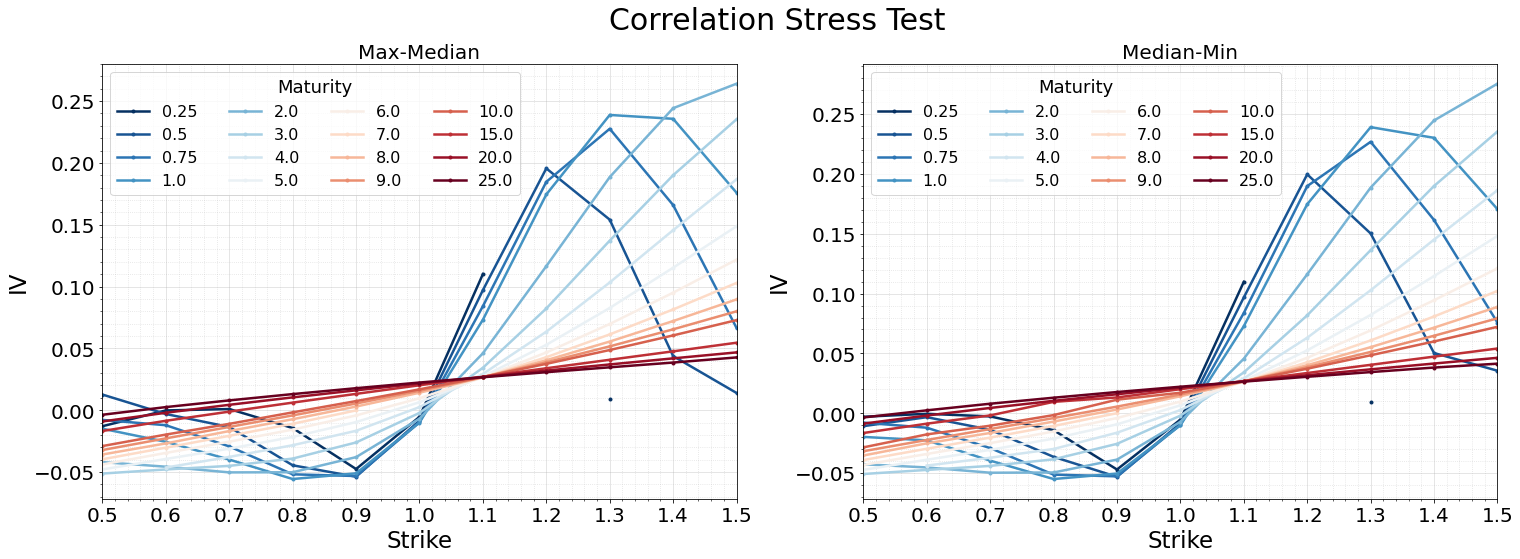

In [8]:
# Example:
StressPlot(parameter='Correlation')

### Then make the plots in Appendix C All parameters IV stressed plots

In [9]:
df = pd.read_excel(r'C:\Users\Roger Cai\OneDrive\Desktop\Moodys_project\Parameter_range.xlsx')
df = pd.DataFrame(df)
# change the name of the parameter to simpler version:
ParaName = ["ArrivalRate", "JumpMean", "JumpVolatility", "Correlation", "MeanReversionLevel", "MeanReversionRate", "InitialValue", "Volatility"]
df.iloc[:8, 0] = ParaName
df = df.set_index('Unnamed: 0')
df.index.name = 'ParentEquityModel'

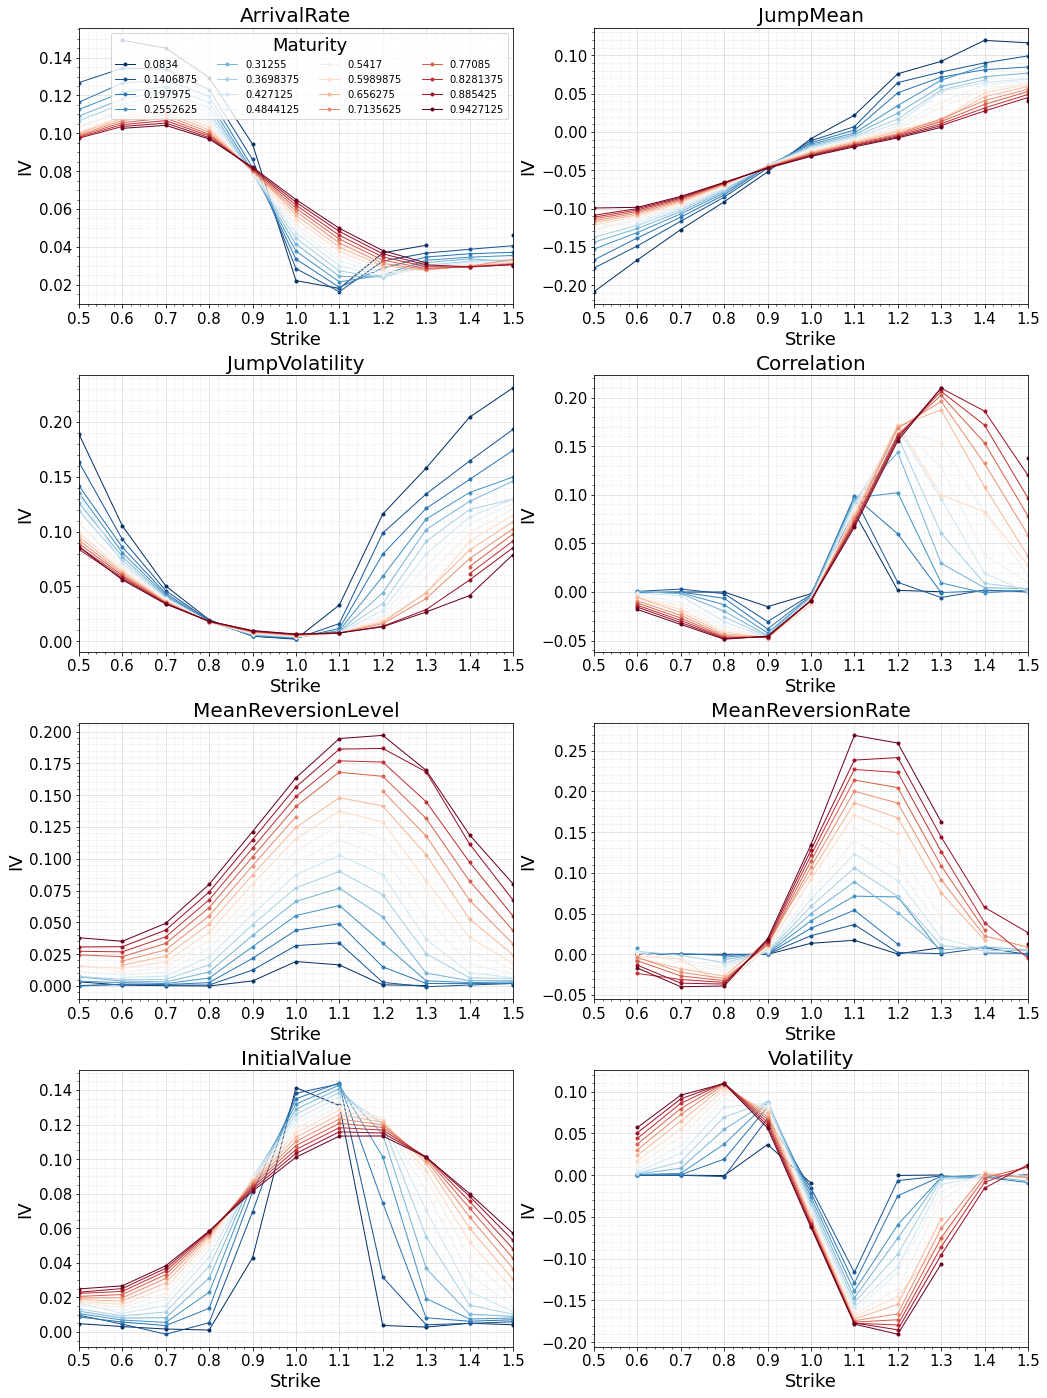

In [10]:
OutputPath_stress = r'C:\Users\Roger Cai\OneDrive\Desktop\output of My Simulations\SecondPartOfTheResult' # User specific
fig, ax = plt.subplots(4,2, figsize=(15,20))
# fig.suptitle('All Parameters Stress Test', fontsize=25)
plt.tight_layout(pad=5)
color = plt.cm.RdBu(np.linspace(0, 1, 16))[::-1]
pivot_array = []
for i, idx in enumerate(df.index):
    temp0 = (Pivot(path=OutputPath_stress, parameter=idx, value="Max", timeStep=0).values-Pivot(path=OutputPath_stress, parameter=idx, value="Median", timeStep=0).values)/np.sqrt(((((Pivot(path=OutputPath_stress, parameter=idx, value="Max", timeStep=0).values-Pivot(path=OutputPath_stress, parameter=idx, value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(path=OutputPath_stress, parameter=idx, value="Max", timeStep=0).values-Pivot(path=OutputPath_stress, parameter=idx, value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
    temp0 = temp0.T
    pivot_array.append(temp0)
df_temp = np.array(pivot_array).reshape((4,2,11,16))

for q,i,j in zip(df.index, [0,0,1,1,2,2,3,3], [0,1,0,1,0,1,0,1]):
    pivot = Pivot(path=OutputPath_stress, parameter=idx, value="Max", timeStep=0)
    for z in range(df_temp.shape[3]):
        ax[i,j].plot(pivot.columns, df_temp[i,j,:,z], color=color[z], label=pivot.index[z], marker='.', linewidth=1)
        if q=='ArrivalRate':
            ax[i,j].legend(title="Maturity", ncol=4, loc='upper right', title_fontsize=18, prop={'size': 10})
    
    xlabels = np.array(pivot.columns)
    ax[i,j].set_xticks(pivot.columns)
    ax[i,j].set_xticklabels(xlabels, fontsize=15)
    ax[i,j].tick_params(axis='y', labelsize= 15)
    ax[i,j].set_xlabel("Strike", fontsize=18)
    ax[i,j].set_ylabel("IV", fontsize=18)
#     ax[i,j].spines['top'].set_visible(False)
#     ax[i,j].spines['right'].set_visible(False)

    ax[i,j].set_title("{}".format(q), fontsize=20)
    ax[i,j].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i,j].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i,j].grid(linestyle='-', which='major', alpha=0.4)
    ax[i,j].grid(linestyle=':', which='minor', alpha=0.4)
    ax[i,j].set_xlim([0.5,1.5])

### 3D plot in Section 2.2

In [11]:
plot_3d_df =  Pivot(parameter='Correlation').copy()
plot_3d_df = plot_3d_df.dropna(axis=0)

Text(0.5, 0, 'IV')

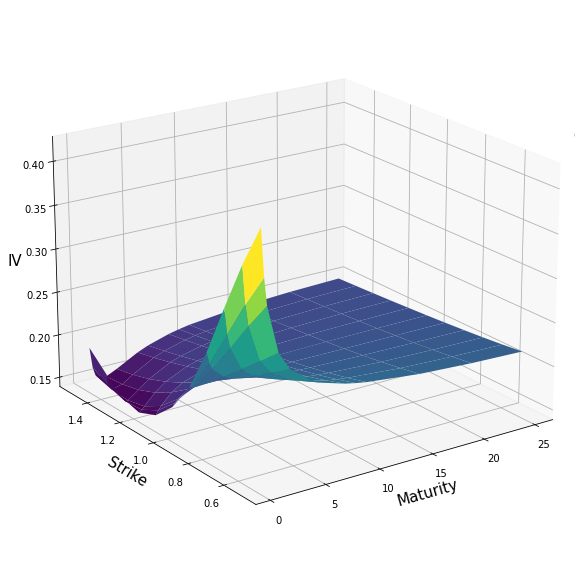

In [12]:
fig = plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(plot_3d_df.index, plot_3d_df.columns)
Z = plot_3d_df.values
Z = Z.T

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.view_init(20, 235)
ax.set_xlabel("Maturity", fontsize=15)
ax.set_ylabel("Strike", fontsize=15)
ax.set_zlabel("IV", fontsize=15)

# Regression Analysis

### The process that I should do for the regression analysis:
- Cleaning out the data
- Making up the Regression Model
- Fitting the data
- Making up the prediction under the original X dataset
##### Use function and for loop
- Calculating the residuals by substracting the predicted values from the observed values
- Calculating the Euclidean norms for each of the parameter, and making up the plots

> Since there are some Nan data in the dataset that we use to produce the residual, therefore, we should drop them in order to fit them into the linear regression model.

> Before droping them, we should note down that which strike and maturity has a Nan value(This has done by adding extra columns for the Strike and Maturity first and droping afterwards).

### Normalise Delta

In [13]:
Delta_ArrivalRate = (Pivot(parameter='ArrivalRate', value="Max", timeStep=0)-Pivot(parameter='ArrivalRate', value="Median", timeStep=0))/np.sqrt(((((Pivot(parameter='ArrivalRate', value="Max", timeStep=0).values-Pivot(parameter='ArrivalRate', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter='ArrivalRate', value="Max", timeStep=0).values-Pivot(parameter='ArrivalRate', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_JumpMean = (Pivot(parameter='JumpMean', value="Max", timeStep=0)-Pivot(parameter='JumpMean', value="Median", timeStep=0))/np.sqrt(((((Pivot(parameter='JumpMean', value="Max", timeStep=0).values-Pivot(parameter='JumpMean', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter='JumpMean', value="Max", timeStep=0).values-Pivot(parameter='JumpMean', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_JumpVolatility = (Pivot(parameter='JumpVolatility', value="Max", timeStep=0)-Pivot(parameter='JumpVolatility', value="Median", timeStep=0))/np.sqrt(((((Pivot(parameter='JumpVolatility', value="Max", timeStep=0).values-Pivot(parameter='JumpVolatility', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter='JumpVolatility', value="Max", timeStep=0).values-Pivot(parameter='JumpVolatility', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_Correlation = (Pivot(parameter='Correlation', value="Max", timeStep=0)-Pivot(parameter='Correlation', value="Median", timeStep=0))/np.sqrt(((((Pivot(parameter='Correlation', value="Max", timeStep=0).values-Pivot(parameter='Correlation', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter='Correlation', value="Max", timeStep=0).values-Pivot(parameter='Correlation', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_MeanReversionLevel = (Pivot(parameter='MeanReversionLevel', value="Max", timeStep=0)-Pivot(parameter='MeanReversionLevel', value="Median", timeStep=0))/np.sqrt(((((Pivot(parameter='MeanReversionLevel', value="Max", timeStep=0).values-Pivot(parameter='MeanReversionLevel', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter='MeanReversionLevel', value="Max", timeStep=0).values-Pivot(parameter='MeanReversionLevel', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_MeanReversionRate = (Pivot(parameter='MeanReversionRate', value="Max", timeStep=0)-Pivot(parameter='MeanReversionRate', value="Median", timeStep=0))/np.sqrt(((((Pivot(parameter='MeanReversionRate', value="Max", timeStep=0).values-Pivot(parameter='MeanReversionRate', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter='MeanReversionRate', value="Max", timeStep=0).values-Pivot(parameter='MeanReversionRate', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_InitialValue = (Pivot(parameter='InitialValue', value="Max", timeStep=0)-Pivot(parameter='InitialValue', value="Median", timeStep=0))/np.sqrt(((((Pivot(parameter='InitialValue', value="Max", timeStep=0).values-Pivot(parameter='InitialValue', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter='InitialValue', value="Max", timeStep=0).values-Pivot(parameter='InitialValue', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_Volatility = (Pivot(parameter='Volatility', value="Max", timeStep=0)-Pivot(parameter='Volatility', value="Median", timeStep=0))/np.sqrt(((((Pivot(parameter='Volatility', value="Max", timeStep=0).values-Pivot(parameter='Volatility', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(parameter='Volatility', value="Max", timeStep=0).values-Pivot(parameter='Volatility', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())

Delta_Total = [Delta_ArrivalRate.values.reshape((-1)), Delta_JumpMean.values.reshape((-1)), Delta_JumpVolatility.values.reshape((-1)), Delta_Correlation.values.reshape((-1)), Delta_MeanReversionLevel.values.reshape((-1)), Delta_MeanReversionRate.values.reshape((-1)), Delta_InitialValue.values.reshape((-1)), Delta_Volatility.values.reshape((-1))]
Name_Parameters = ['ArrivalRate', 'JumpMean', 'JumpVolatility', 'Correlation', 'MeanReversionLevel', 'MeanReversionRate', 'InitialValue', 'Volatility', 'Strike', 'Maturity']

In [14]:
temp_df = pd.DataFrame(Delta_Total).T
temp_df.columns = Name_Parameters[0:-2]
SM_getting = Delta_ArrivalRate

X_, Y_ = np.meshgrid(SM_getting.columns, SM_getting.index)
Y_ = Y_.reshape((-1))
X_ = X_.reshape((-1))
temp_df['Strike'] = X_
temp_df['Maturity'] = Y_

# dropna values
temp_df = temp_df.dropna(axis=0)
temp_df = temp_df.reset_index(drop=True)
temp_df.columns = Name_Parameters

In [15]:
# Example of cleaned DataFrame:
temp_df

,ArrivalRate,JumpMean,JumpVolatility,Correlation,MeanReversionLevel,MeanReversionRate,InitialValue,Volatility,Strike,Maturity
0,0.105503,-0.200032,0.273344,-0.012912,0.000793,0.014401,0.016590,-0.003330,0.5,0.25
1,0.113859,-0.171546,0.162915,-0.000168,0.000575,0.002302,0.010725,0.000535,0.6,0.25
2,0.116638,-0.139196,0.085014,0.000965,0.000409,0.003710,0.008439,0.002719,0.7,0.25
3,0.074634,-0.057164,0.010928,-0.047566,0.006734,0.000313,0.136301,0.067078,0.9,0.25
4,0.034876,-0.020749,0.006452,-0.005337,0.012187,0.010964,0.209768,-0.019786,1.0,0.25
...,...,...,...,...,...,...,...,...,...,...
163,0.078890,-0.070795,0.048840,0.026662,0.100975,0.063957,0.010776,-0.045957,1.1,25.00
164,0.079102,-0.070284,0.048220,0.030748,0.101931,0.070123,0.010886,-0.050761,1.2,25.00
165,0.079250,-0.069780,0.047651,0.034700,0.102832,0.075884,0.010991,-0.055225,1.3,25.00
166,0.079374,-0.069279,0.047127,0.038551,0.103685,0.081257,0.011092,-0.059396,1.4,25.00


### Stressed plot in Section 6.3.1

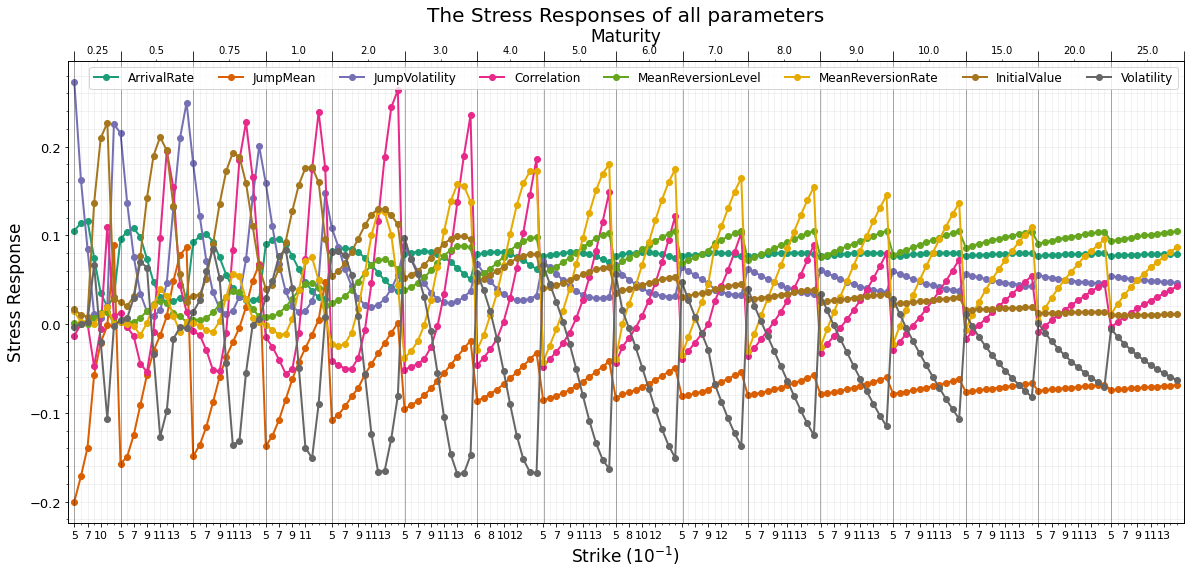

In [16]:
fig, ax = plt.subplots(1,1, figsize=(20,8.5))
color = plt.cm.Dark2(np.linspace(0,1,8))

# for i in range(len(temp_df.columns)-2):

ln0 = ax.plot(temp_df.iloc[:, 0], color=color[0], linewidth = 2, marker = '.', ms = 12, label=temp_df.columns[0])
ln1 = ax.plot(temp_df.iloc[:, 1], color=color[1], linewidth = 2, marker = '.', ms = 12, label=temp_df.columns[1])
ln2 = ax.plot(temp_df.iloc[:, 2], color=color[2], linewidth = 2, marker = '.', ms = 12, label=temp_df.columns[2])
ln3 = ax.plot(temp_df.iloc[:, 3], color=color[3], linewidth = 2, marker = '.', ms = 12, label=temp_df.columns[3])
ln4 = ax.plot(temp_df.iloc[:, 4], color=color[4], linewidth = 2, marker = '.', ms = 12, label=temp_df.columns[4])
ln5 = ax.plot(temp_df.iloc[:, 5], color=color[5], linewidth = 2, marker = '.', ms = 12, label=temp_df.columns[5])
ln6 = ax.plot(temp_df.iloc[:, 6], color=color[6], linewidth = 2, marker = '.', ms = 12, label=temp_df.columns[6])
ln7 = ax.plot(temp_df.iloc[:, 7], color=color[7], linewidth = 2, marker = '.', ms = 12, label=temp_df.columns[7])

majors = [0, 2, 4, 7,9,11,13,15,18,20,22,24,26,29,31,33,35,39,41,43,45,47,50,52,54,56,58,61,63,65,67,71,73,75,77,79,82,84,86,88,92,94,96,98,102,104,106,108,110,113,115,117,119,121,124,126,128,130,132,135,137,139,141,143,146,148,150,152,154,157,159,161,163,165]
Strike_ = []                      
for i in majors:
    Strike_.append(int((temp_df.loc[:,'Strike']*10).values[i]))
## here, the *10 is just for scaling and make the plot look not very crowded, and we will change the label to 10^{-1} later

ax.grid(which='both', alpha = 0.2)
ax.tick_params(axis='x', which='major', labelsize=11)
ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(majors))
ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(Strike_))
ax.set_xticks([i for i in range(len(temp_df))], minor=True)
ax.set_xlabel('Strike ($10^{-1}$)', fontsize=17)

ax2 = ax.twiny()
ax2.set_xticks([i for i in range(len(temp_df))], minor=False)

ax2.set_xticks([4.4, 13.25, 24.2, 34.6, 44.95, 55.8, 66.2, 76.6, 87, 96.9, 107.2, 118.05, 128.95, 139.8, 150.65, 161.55], minor=True)
majors_2 = [1, 8, 18.7, 29.7, 39.5, 50.4, 61.2, 71.2, 82, 92, 101.8, 112.6, 123.5, 134.4, 145.2, 156.1, 167]
Maturity_ = np.hstack([0, temp_df.loc[:, 'Maturity'].unique()])
ax2.tick_params(axis='x', which='major', labelsize=13)
ax2.grid(which = 'major', c='black', alpha=0.4)
ax2.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(majors_2))
ax2.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(Maturity_))
ax2.set_xlabel('Maturity', fontsize = 17)
ax2.set_xticklabels([])
ax2.set_xticklabels(list(temp_df['Maturity'].unique()), minor=True)
ax2.tick_params(length=10)

# added these three lines
lns = ln0+ln1+ln2+ln3+ln4+ln5+ln6+ln7
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0, ncol=len(temp_df.columns), prop={'size': 12})

ax.set_ylabel('Stress Response', fontsize=17)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='y', which='major', labelsize=13)

plt.title('The Stress Responses of all parameters', fontsize=20)

ax.set_xlim(-1,168)

plt.savefig('RESPONSE.png', dpi=300)
plt.show()

### Fitting Linear Regression Model and Calculating the norm
> As we used the linear regression model to make the prediction of the response, we could easily get the residual value and norm of the residual of each parameter:

In [17]:
def Get_Residual_Norm(paramIgnore):
    '''
    This function is to do the regression fit by deciding which Delta we are going to use to fit the model.
    
    Input: str, list of str, None
        str: the input of the function is the parameter's name that we want to exclude from the regression fitting.
        None: represents there are no parameters that we want to exclude
        list of str: a list of parameters' name that we want to exclude from the regression model
        
    Output: DataFrame_1, DataFrame_2
        DataFrame_1 : the residuals of all parameters include the labels of strikes and maturities
        DataFrame_2 : the Euclidean norm of residuals of each parameter which we get from DataFrame_1
    '''
    Name_Parameters = ['ArrivalRate', 'JumpMean', 'JumpVolatility', 'Correlation', 'MeanReversionLevel', 'MeanReversionRate', 'InitialValue', 'Volatility', 'Strike', 'Maturity']
        
    def baseModel():
        '''
        This function is helping us to fit the parameters' Delta into the linear regression model, and calculate the
        residual and norm
        
        Output: DataFrame_1, DataFrame_2
            Two DataFrames are defined the same as previous definition
        '''
        
        residual = []
        
        # temp_df is the DataFrame that contains all the IV variation of stressed parameters
        # loop through regression fitting of all parameter's IV variation
        for i, idx in enumerate(temp_df.columns[0:8]):
            y = temp_df.loc[:, idx]
            x = temp_df.drop([idx, 'Strike', 'Maturity'], axis=1)

            # fit model:
            reg = LinearRegression().fit(x,y)

            # predicted value of the IV:
            y_predict = reg.predict(x)
            residual_ = y - y_predict
            residual.append(residual_)

        # change the residual list to DataFrame, and labelling
        residual = np.array(residual)
        residual = pd.DataFrame(residual).T
        residual['Strike'], residual['Maturity'] = temp_df['Strike'], temp_df['Maturity']
        name = Name_Parameters.copy()
        residual.columns = name

        # calculate the Euclidean norm of the residuals:
        norm = []
        for j in Name_Parameters[0:-2]:
            norm_ = LA.norm(np.array(residual.loc[:, j]), 2)
            norm.append(norm_)

        norm_df = pd.DataFrame(norm).T
        norm_df.columns = Name_Parameters[0:-2].copy()
        
        return residual, norm_df
    
    # Detailed comments have done above, the comments ignored below will be the same as above as the process above
    
    # if there is no excluded parameter
    if paramIgnore == None:
        # call the function above
        residual, norm = baseModel()
        return residual, norm
    
    else:
        # if data type is a list, we do this:
        if type(paramIgnore) == list:
            column_names = temp_df.columns
            temp_ignored = temp_df.iloc[:, :8]
            temp_ignored = temp_ignored.drop(paramIgnore, axis=1)

            residual=[]
            for i, idx in enumerate(temp_ignored.columns):
                y = temp_ignored.loc[:, idx]
                x = temp_ignored.drop(idx, axis=1)

                # fit model:
                reg = LinearRegression().fit(x,y)

                # predicted value of the IV:
                y_predict = reg.predict(x)
                residual_ = y - y_predict
                residual.append(residual_)

            residual = np.array(residual)
            residual = pd.DataFrame(residual).T
            residual['Strike'], residual['Maturity'] = temp_df['Strike'], temp_df['Maturity']

            temp_new_name = Name_Parameters.copy()
            for eles in temp_new_name:
                for j in paramIgnore:
                    if j in temp_new_name:
                        temp_new_name.remove(j)

            residual.columns = temp_new_name

            res, _ = baseModel()
            for z in residual.columns:
                res[z] = residual[z]


            # calculate the Euclidean norm of the residuals:
            norm = []
            for j in Name_Parameters[0:-2]:
                norm_ = LA.norm(np.array(res.loc[:, j]), 2)
                norm.append(norm_)

            norm_df = pd.DataFrame(norm).T
            norm_df.columns = Name_Parameters[0:-2]

            return res, norm_df
        
        # if the data type is a single str, we do this:
        else:
            column_names = temp_df.columns
            temp_ignored = temp_df.iloc[:, :8]
            temp_ignored = temp_ignored.drop(paramIgnore, axis=1)

            residual=[]
            for i, idx in enumerate(temp_ignored.columns):
                y = temp_ignored.loc[:, idx]
                x = temp_ignored.drop(idx, axis=1)

                # fit model:
                reg = LinearRegression().fit(x,y)

                # predicted value of the IV:
                y_predict = reg.predict(x)
                residual_ = y - y_predict
                residual.append(residual_)

            residual = np.array(residual)
            residual = pd.DataFrame(residual).T
            residual['Strike'], residual['Maturity'] = temp_df['Strike'], temp_df['Maturity']
            name = Name_Parameters.copy()
            name.remove(paramIgnore)
            residual.columns = name

            res, _ = baseModel()
            for z in residual.columns:
                res[z] = residual[z]


            # calculate the Euclidean norm of the residuals:
            norm = []
            for j in Name_Parameters[0:-2]:
                norm_ = LA.norm(np.array(res.loc[:, j]), 2)
                norm.append(norm_)

            norm_df = pd.DataFrame(norm).T
            norm_df.columns = Name_Parameters[0:-2]

            return res, norm_df

In [18]:
# Example:
residual, norm = Get_Residual_Norm(None)

In [19]:
residual

,ArrivalRate,JumpMean,JumpVolatility,Correlation,MeanReversionLevel,MeanReversionRate,InitialValue,Volatility,Strike,Maturity
0,0.004193,-0.001675,0.066364,0.007682,0.024681,-0.007907,0.034074,0.007839,0.5,0.25
1,0.003758,0.008722,0.010315,0.039806,0.000568,-0.023084,0.004366,-0.040015,0.6,0.25
2,0.001678,0.010623,-0.035322,0.040550,-0.020191,-0.023432,-0.021441,-0.064776,0.7,0.25
3,-0.004123,-0.012554,-0.025442,-0.031782,-0.013097,0.029806,-0.012848,0.037939,0.9,0.25
4,-0.012366,-0.046028,-0.043511,-0.132144,-0.023853,0.051665,-0.029468,0.035197,1.0,0.25
...,...,...,...,...,...,...,...,...,...,...
163,-0.001371,-0.004813,-0.006451,-0.005689,-0.002403,0.003205,-0.005499,0.001112,1.1,25.00
164,-0.001437,-0.005072,-0.006608,-0.005844,-0.002580,0.004197,-0.005645,0.002286,1.2,25.00
165,-0.001533,-0.005447,-0.006881,-0.006163,-0.002813,0.005270,-0.005878,0.003518,1.3,25.00
166,-0.001617,-0.005776,-0.007112,-0.006320,-0.003014,0.006246,-0.006077,0.004680,1.4,25.00


In [20]:
norm

,ArrivalRate,JumpMean,JumpVolatility,Correlation,MeanReversionLevel,MeanReversionRate,InitialValue,Volatility
0,0.028021,0.111567,0.142471,0.358988,0.074628,0.135536,0.098569,0.202311


### Making up the risidual plot

In [21]:
def Risidual_Plot(residual=None, exclude=None):
    fig, ax = plt.subplots(1,1, figsize=(20,8.5))
    color = plt.cm.Dark2(np.linspace(0,1,8))

    # for i in range(len(temp_df.columns)-2):

    ln0 = ax.plot(residual.iloc[:, 0], color=color[0], linewidth = 2, marker = '.', ms = 12, label=residual.columns[0])
    ln1 = ax.plot(residual.iloc[:, 1], color=color[1], linewidth = 2, marker = '.', ms = 12, label=residual.columns[1])
    ln2 = ax.plot(residual.iloc[:, 2], color=color[2], linewidth = 2, marker = '.', ms = 12, label=residual.columns[2])
    ln3 = ax.plot(residual.iloc[:, 3], color=color[3], linewidth = 2, marker = '.', ms = 12, label=residual.columns[3])
    ln4 = ax.plot(residual.iloc[:, 4], color=color[4], linewidth = 2, marker = '.', ms = 12, label=residual.columns[4])
    ln5 = ax.plot(residual.iloc[:, 5], color=color[5], linewidth = 2, marker = '.', ms = 12, label=residual.columns[5])
    ln6 = ax.plot(residual.iloc[:, 6], color=color[6], linewidth = 2, marker = '.', ms = 12, label=residual.columns[6])
    ln7 = ax.plot(residual.iloc[:, 7], color=color[7], linewidth = 2, marker = '.', ms = 12, label=residual.columns[7])

    majors = [0, 2, 4, 7,9,11,13,15,18,20,22,24,26,29,31,33,35,39,41,43,45,47,50,52,54,56,58,61,63,65,67,71,73,75,77,79,82,84,86,88,92,94,96,98,102,104,106,108,110,113,115,117,119,121,124,126,128,130,132,135,137,139,141,143,146,148,150,152,154,157,159,161,163,165]
    Strike_ = []                      
    for i in majors:
        Strike_.append(int((temp_df.loc[:,'Strike']*10).values[i]))
    ## here, the *10 is just for scaling and make the plot look not very crowded, and we will change the label to 10^{-1} later

    ax.grid(which='both', alpha = 0.2)
    ax.tick_params(axis='x', which='major', labelsize=11)
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(majors))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(Strike_))
    ax.set_xticks([i for i in range(len(temp_df))], minor=True)
    ax.set_xlabel('Strike ($10^{-1}$)', fontsize=17)

    ax2 = ax.twiny()
    ax2.set_xticks([i for i in range(len(temp_df))], minor=False)
    ax2.set_xticks([4.4, 13.25, 24.2, 34.6, 44.95, 55.8, 66.2, 76.6, 87, 96.9, 107.2, 118.05, 128.95, 139.8, 150.65, 161.55], minor=True)
    majors_2 = [1, 8, 18.7, 29.7, 39.5, 50.4, 61.2, 71.2, 82, 92, 101.8, 112.6, 123.5, 134.4, 145.2, 156.1, 167]
    Maturity_ = np.hstack([0, temp_df.loc[:, 'Maturity'].unique()])
    ax2.tick_params(axis='x', which='major', labelsize=13)
    ax2.grid(which = 'major', c='black', alpha=0.4)
    ax2.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(majors_2))
    ax2.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(Maturity_))
    ax2.set_xlabel('Maturity', fontsize=17)
    ax2.set_xticklabels([])
    ax2.set_xticklabels(list(temp_df['Maturity'].unique()), minor=True)
    ax2.tick_params(length=10)


    # added these three lines
    lns = ln0+ln1+ln2+ln3+ln4+ln5+ln6+ln7
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0, ncol=len(temp_df.columns), prop={'size': 12})
    
    ax.set_ylabel('Residual Response', fontsize=17)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='y', which='major', labelsize=13)

    plt.title('Residual, {} excluded, all parameters'.format(exclude), fontsize=20)

    ax.set_xlim(-1,168)

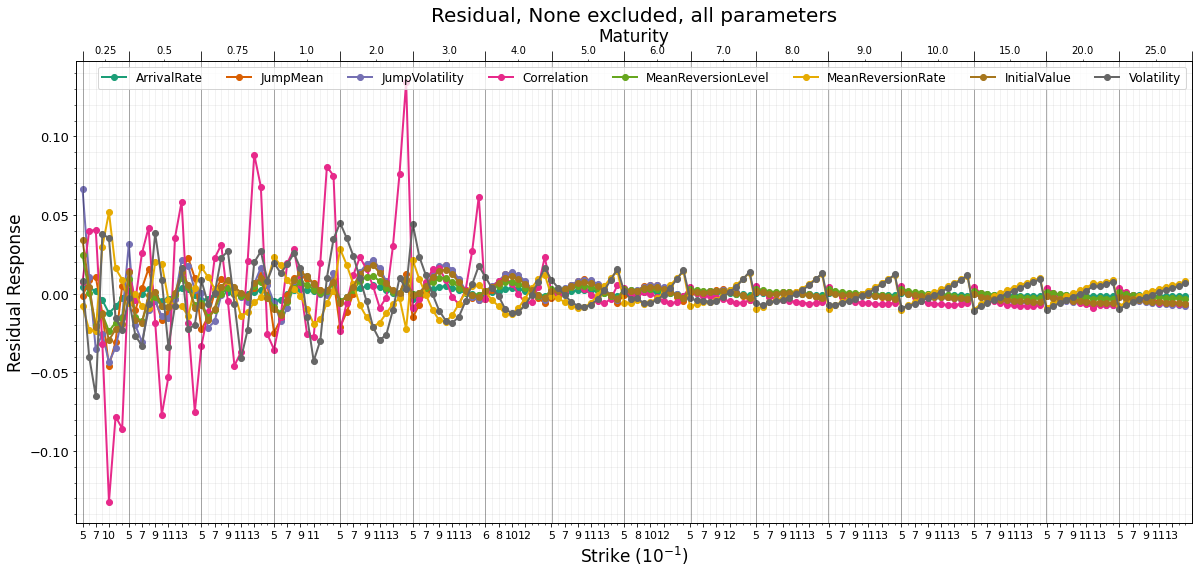

In [22]:
Risidual_Plot(residual=residual)

### Excluding ArrivalRate

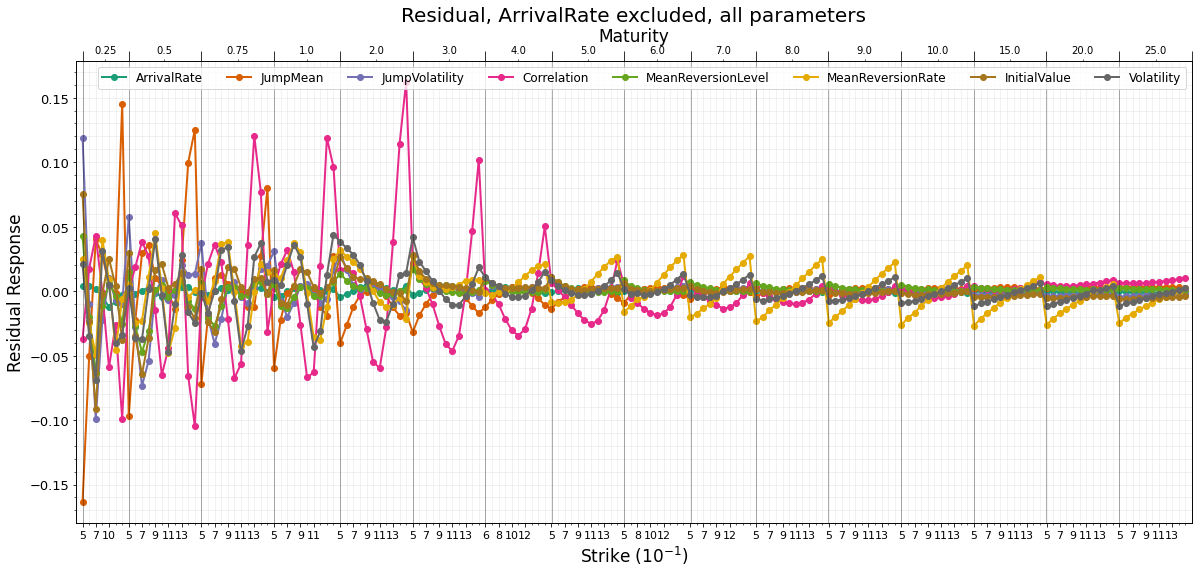

In [23]:
exclude_ArrivalRate_residual, exclude_ArrivalRate_norm = Get_Residual_Norm('ArrivalRate')
Risidual_Plot(residual=exclude_ArrivalRate_residual, exclude='ArrivalRate')


### Here, we want to get only the residuals of JumpMean and residuals of JumpVolatility under both non-excluded and excude ArriavalRate:

In [24]:
All_residual = residual.copy()
ArrivalRate_excluded_residual = exclude_ArrivalRate_residual.copy()
a_temp = pd.concat([All_residual.loc[:,['JumpMean', 'JumpVolatility']], ArrivalRate_excluded_residual.loc[:,['JumpMean', 'JumpVolatility']]], axis=1)
a_temp = pd.concat([a,ArrivalRate_excluded_residual.iloc[:, -2:]],axis=1)
a_temp.columns = ['JumpMean (noexclude)', 'JumpVolatility (noexclude)', 'JumpMean (exclude_ArrivalRate)', 'JumpVolatility (exclude_ArrivalRate)', 'Strike', 'Maturity']
a_temp

### Plot:

In [25]:
def Risidual_Plot_temp(residual=None, exclude=None):
    fig, ax = plt.subplots(1,1, figsize=(20,8.5))
    color = plt.cm.Dark2(np.linspace(0,1,4))

    ln0 = ax.plot(residual.iloc[:, 0], color=color[0], linewidth = 2, marker = '.', ms = 12, label=residual.columns[0])
    ln1 = ax.plot(residual.iloc[:, 1], color=color[1], linewidth = 2, marker = '.', ms = 12, label=residual.columns[1])
    ln2 = ax.plot(residual.iloc[:, 2], color=color[2], linewidth = 2, marker = '.', ms = 12, label=residual.columns[2])
    ln3 = ax.plot(residual.iloc[:, 3], color=color[3], linewidth = 2, marker = '.', ms = 12, label=residual.columns[3])

    majors = [0, 2, 4, 7,9,11,13,15,18,20,22,24,26,29,31,33,35,39,41,43,45,47,50,52,54,56,58,61,63,65,67,71,73,75,77,79,82,84,86,88,92,94,96,98,102,104,106,108,110,113,115,117,119,121,124,126,128,130,132,135,137,139,141,143,146,148,150,152,154,157,159,161,163,165]
    Strike_ = []                      
    for i in majors:
        Strike_.append(int((temp_df.loc[:,'Strike']*10).values[i]))
    ## here, the *10 is just for scaling and make the plot look not very crowded, and we will change the label to 10^{-1} later

    ax.grid(which='both', alpha = 0.2)
    ax.tick_params(axis='x', which='major', labelsize=11)
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(majors))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(Strike_))
    ax.set_xticks([i for i in range(len(temp_df))], minor=True)
    ax.set_xlabel('Strike ($10^{-1}$)', fontsize=17)

    ax2 = ax.twiny()
    ax2.set_xticks([i for i in range(len(temp_df))], minor=False)
    ax2.set_xticks([4.4, 13.25, 24.2, 34.6, 44.95, 55.8, 66.2, 76.6, 87, 96.9, 107.2, 118.05, 128.95, 139.8, 150.65, 161.55], minor=True)
    majors_2 = [1, 8, 18.7, 29.7, 39.5, 50.4, 61.2, 71.2, 82, 92, 101.8, 112.6, 123.5, 134.4, 145.2, 156.1, 167]
    Maturity_ = np.hstack([0, temp_df.loc[:, 'Maturity'].unique()])
    ax2.tick_params(axis='x', which='major', labelsize=13)
    ax2.grid(which = 'major', c='black', alpha=0.4)
    ax2.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(majors_2))
    ax2.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(Maturity_))
    ax2.set_xlabel('Maturity', fontsize=17)
    ax2.set_xticklabels([])
    ax2.set_xticklabels(list(temp_df['Maturity'].unique()), minor=True)
    ax2.tick_params(length=10)


    # added these three lines
    lns = ln0+ln1+ln2+ln3
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0, ncol=len(temp_df.columns), prop={'size': 12})
    
    ax.set_ylabel('Residual Response', fontsize=17)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='y', which='major', labelsize=13)

    plt.title('Residual, Before and After excluding ArrivalRate', fontsize=20)

    ax.set_xlim(-1,168)

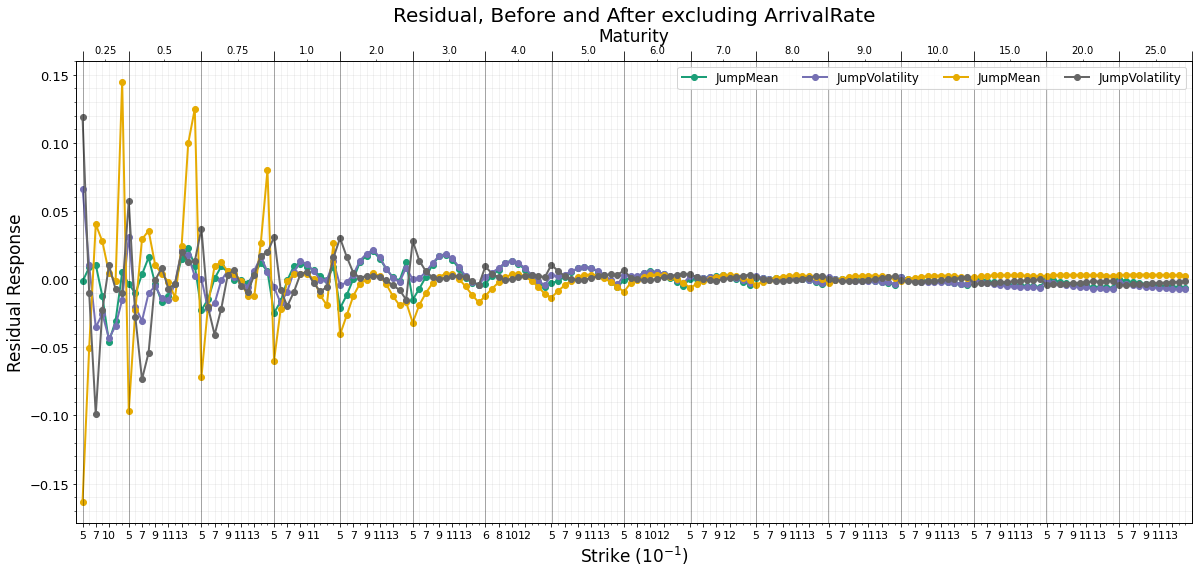

In [26]:
Risidual_Plot_temp(residual=a_temp)

### An updated version of above residual plot function
> This has been used to make the plots in Section 6.4

In [42]:
def residual_plot_total_automatic(residual=None, exclude=None):
    '''
    The function is a updated version of the above plot. In this function, we droped all magic number and make them to be 
    completely automatic. The function is having the same documentation as the one shown above
    '''
    
    # Making up the plot:
    residual = residual.copy()
    fig, ax = plt.subplots(1,1, figsize=(20,8.5))
    color = plt.cm.Dark2(np.linspace(0,1,8))
    ln0 = ax.plot(residual.iloc[:, 0], color=color[0], linewidth = 2, marker = '.', ms = 12, label=residual.columns[0])
    ln1 = ax.plot(residual.iloc[:, 1], color=color[1], linewidth = 2, marker = '.', ms = 12, label=residual.columns[1])
    ln2 = ax.plot(residual.iloc[:, 2], color=color[2], linewidth = 2, marker = '.', ms = 12, label=residual.columns[2])
    ln3 = ax.plot(residual.iloc[:, 3], color=color[3], linewidth = 2, marker = '.', ms = 12, label=residual.columns[3])
    ln4 = ax.plot(residual.iloc[:, 4], color=color[4], linewidth = 2, marker = '.', ms = 12, label=residual.columns[4])
    ln5 = ax.plot(residual.iloc[:, 5], color=color[5], linewidth = 2, marker = '.', ms = 12, label=residual.columns[5])
    ln6 = ax.plot(residual.iloc[:, 6], color=color[6], linewidth = 2, marker = '.', ms = 12, label=residual.columns[6])
    ln7 = ax.plot(residual.iloc[:, 7], color=color[7], linewidth = 2, marker = '.', ms = 12, label=residual.columns[7])

    # then we need to make the complicated ticks, in which, there are some magic number list we should set, they need to be done manually:
    ax.grid(which='both', alpha = 0.2)
    ax.tick_params(axis='x', which='major', labelsize=11) # the majorticks are set here, but they are not in a right location, and not named in a right format

    # we then need to make a automation for the python to get the correct location and format

    # I then want to set the location of ticks that I want to show the strikes on x-axis_1, as there will be too many labels later
    # I want only to show three ticks in each maturity, therefore, the whole range will be 
    No_Strike_each_Maturity = np.hstack([0, temp_df.groupby(by='Maturity').size().values.cumsum()])

    # we want to have three ticks for each maturity, therefore:
    Three_ticks_each_maturity = [[i, i+2, i+4] for i in No_Strike_each_Maturity[:-1]]+[[No_Strike_each_Maturity[-1]]]

    # we want to concatenate them all together
    major_ticks_location = []
    for i in Three_ticks_each_maturity:
        major_ticks_location = major_ticks_location + i

    # the result will be a list, with all the tick location:
    major_ticks_location = major_ticks_location[:-1]

    # therefore, related to the location, the label of the ticks will be defined as 
    Strike_labels = []
    for i in major_ticks_location:
        Strike_labels.append(int((temp_df.loc[:,'Strike']*10).values[i]))
    # Now we have the label of the ticks

    ax.grid(which='both', alpha = 0.2)
    ax.tick_params(axis='x', which='major', labelsize=11)
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(major_ticks_location))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(Strike_labels))
    ax.set_xticks([i for i in range(len(temp_df))], minor=True)
    ax.set_xlabel('Strike ($10^{-1}$)', fontsize=17)
    ax.set_xlim(-1,len(temp_df))

    # by using above setting, we have the first x-axis ticks
    # then, we want to have the ticks that fix on the top to represent the maturities
    # first set major ticks
    ax2 = ax.twiny()
    ax2.set_xticks([i for i in range(len(temp_df))], minor=False)

    # then get the location of the major point that we need:
    major_location_axis2 = No_Strike_each_Maturity.copy()
    ax2.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(major_location_axis2))
    ax2.set_xticklabels([])
    ax2.set_xlim(-1,len(temp_df))
    ax2.tick_params(length=10)

    # then for the minor ticks:
    # the reason that we want to set the minor ticks is because that we want to use these ticks to label the name of the time-to-maturities
    # therefore, they should be at the middle point of each major tick
    # follow up the next cell for how we get the minor location
    # we want to get the minor ticks location
    minor_ticks_location = []
    for i in range(len(major_location_axis2)-1):
        minor_ticks_location.append((major_location_axis2[i]+major_location_axis2[i+1])/2)
    ax2.set_xticks(minor_ticks_location, minor=True)
    ax2.tick_params(axis='x', which='major', labelsize=13)
    ax2.grid(which = 'major', c='black', alpha=0.4)
    ax2.set_xlabel('Maturity', fontsize=17)
    ax2.set_xticklabels(list(temp_df['Maturity'].unique()), minor=True)

     # added these three lines for legend:
    lns = ln0+ln1+ln2+ln3+ln4+ln5+ln6+ln7
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0, ncol=len(temp_df.columns), prop={'size': 12})

    # y-axis setting up
    ax.set_ylabel('Residual Response', fontsize=17)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='y', which='major', labelsize=13)

    # title
    plt.title('Residual, {} excluded, all parameters'.format(exclude), fontsize=20)

In [43]:
OutputPath_stress = r'C:\Users\Roger Cai\OneDrive\Desktop\output of My Simulations\SecondPartOfTheResult'
Pivot(path = OutputPath_stress, parameter='ArrivalRate')

Strike,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5
Maturity,,,,,,,,,,,
0.083400,NaN,0.714997,0.572868,0.417404,0.251266,0.161826,0.148689,0.218747,0.287779,NaN,0.391249
0.140687,0.684093,0.587497,0.477197,0.354252,0.229541,0.165131,0.146231,0.178343,0.232459,0.276670,0.313381
0.197975,0.599437,0.518858,0.425692,0.321179,0.221240,0.167693,0.147114,0.159379,0.202924,0.240683,0.271915
0.255263,0.544529,0.474222,0.392265,0.300743,0.217195,0.169827,0.148472,0.150761,0.184033,0.217451,0.245167
0.312550,0.505238,0.442199,0.368425,0.286999,0.214939,0.171670,0.149917,0.147083,0.171101,0.200902,0.226008
0.369837,0.475344,0.417793,0.350440,0.277213,0.213584,0.173302,0.151354,0.145647,0.162181,0.188418,0.211624
0.427125,NaN,0.398426,0.336363,0.269937,0.212704,0.174771,0.152761,0.145245,0.156165,0.178748,0.200206
0.484413,0.432256,0.382608,0.325051,0.264335,0.212131,0.176108,0.154124,0.145364,0.152206,0.171121,0.190934
0.541700,0.416053,0.369412,0.315771,0.259897,0.211745,0.177337,0.155443,0.145769,0.149661,0.165194,0.183217


### Normalisation:

In [56]:
Delta_ArrivalRate_2 = (Pivot(path = OutputPath_stress, parameter='ArrivalRate', value="Max", timeStep=0)-Pivot(path = OutputPath_stress, parameter='ArrivalRate', value="Median", timeStep=0))/np.sqrt(((((Pivot(path = OutputPath_stress, parameter='ArrivalRate', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress, parameter='ArrivalRate', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(path = OutputPath_stress, parameter='ArrivalRate', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress, parameter='ArrivalRate', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_JumpMean_2 = (Pivot(path = OutputPath_stress, parameter='JumpMean', value="Max", timeStep=0)-Pivot(path = OutputPath_stress, parameter='JumpMean', value="Median", timeStep=0))/np.sqrt(((((Pivot(path = OutputPath_stress, parameter='JumpMean', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress, parameter='JumpMean', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(path = OutputPath_stress, parameter='JumpMean', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress, parameter='JumpMean', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_JumpVolatility_2 = (Pivot(path = OutputPath_stress, parameter='JumpVolatility', value="Max", timeStep=0)-Pivot(path = OutputPath_stress, parameter='JumpVolatility', value="Median", timeStep=0))/np.sqrt(((((Pivot(path = OutputPath_stress, parameter='JumpVolatility', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress, parameter='JumpVolatility', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(path = OutputPath_stress, parameter='JumpVolatility', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress, parameter='JumpVolatility', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_Correlation_2 = (Pivot(path = OutputPath_stress, parameter='Correlation', value="Max", timeStep=0)-Pivot(path = OutputPath_stress, parameter='Correlation', value="Median", timeStep=0))/np.sqrt(((((Pivot(path = OutputPath_stress, parameter='Correlation', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress, parameter='Correlation', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(path = OutputPath_stress, parameter='Correlation', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress, parameter='Correlation', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_MeanReversionLevel_2 = (Pivot(path = OutputPath_stress, parameter='MeanReversionLevel', value="Max", timeStep=0)-Pivot(path = OutputPath_stress, parameter='MeanReversionLevel', value="Median", timeStep=0))/np.sqrt(((((Pivot(path = OutputPath_stress, parameter='MeanReversionLevel', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress, parameter='MeanReversionLevel', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(path = OutputPath_stress, parameter='MeanReversionLevel', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress, parameter='MeanReversionLevel', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_MeanReversionRate_2 = (Pivot(path = OutputPath_stress,parameter='MeanReversionRate', value="Max", timeStep=0)-Pivot(path = OutputPath_stress,parameter='MeanReversionRate', value="Median", timeStep=0))/np.sqrt(((((Pivot(path = OutputPath_stress,parameter='MeanReversionRate', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress,parameter='MeanReversionRate', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(path = OutputPath_stress,parameter='MeanReversionRate', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress,parameter='MeanReversionRate', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_InitialValue_2 = (Pivot(path = OutputPath_stress,parameter='InitialValue', value="Max", timeStep=0)-Pivot(path = OutputPath_stress,parameter='InitialValue', value="Median", timeStep=0))/np.sqrt(((((Pivot(path = OutputPath_stress,parameter='InitialValue', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress,parameter='InitialValue', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(path = OutputPath_stress,parameter='InitialValue', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress,parameter='InitialValue', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())
Delta_Volatility_2 = (Pivot(path = OutputPath_stress,parameter='Volatility', value="Max", timeStep=0)-Pivot(path = OutputPath_stress,parameter='Volatility', value="Median", timeStep=0))/np.sqrt(((((Pivot(path = OutputPath_stress,parameter='Volatility', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress,parameter='Volatility', value="Median", timeStep=0).values)**2).reshape(-1))[~np.isnan((((Pivot(path = OutputPath_stress,parameter='Volatility', value="Max", timeStep=0).values-Pivot(path = OutputPath_stress,parameter='Volatility', value="Median", timeStep=0).values)**2).reshape(-1)))]).sum())

Delta_Total_2 = [Delta_ArrivalRate_2.values.reshape((-1)), Delta_JumpMean_2.values.reshape((-1)), Delta_JumpVolatility_2.values.reshape((-1)), Delta_Correlation_2.values.reshape((-1)), Delta_MeanReversionLevel_2.values.reshape((-1)), Delta_MeanReversionRate_2.values.reshape((-1)), Delta_InitialValue_2.values.reshape((-1)), Delta_Volatility_2.values.reshape((-1))]
Name_Parameters_2 = ['ArrivalRate', 'JumpMean', 'JumpVolatility', 'Correlation', 'MeanReversionLevel', 'MeanReversionRate', 'InitialValue', 'Volatility', 'Strike', 'Maturity']

### Sort the data we need for the regession fitting

In [57]:
temp_df_2 = pd.DataFrame(Delta_Total_2).T
temp_df_2.columns = Name_Parameters_2[0:-2]
SM_getting_2 = Delta_ArrivalRate_2

X_2, Y_2 = np.meshgrid(SM_getting_2.columns, SM_getting_2.index)
Y_2 = Y_2.reshape((-1))
X_2 = X_2.reshape((-1))
temp_df_2['Strike'] = X_2
temp_df_2['Maturity'] = Y_2

# dropna values
temp_df_2 = temp_df_2.dropna(axis=0)
temp_df_2 = temp_df_2.reset_index(drop=True)
temp_df_2.columns = Name_Parameters_2

In [58]:
temp_df_2

,ArrivalRate,JumpMean,JumpVolatility,Correlation,MeanReversionLevel,MeanReversionRate,InitialValue,Volatility,Strike,Maturity
0,0.149097,-0.167192,0.105239,-0.000903,0.000635,0.000262,0.003063,0.000012,0.6,0.083400
1,0.144985,-0.127510,0.050427,-0.000061,0.000205,0.000143,0.001663,-0.000021,0.7,0.083400
2,0.129402,-0.091255,0.019678,-0.000056,-0.000055,0.000066,0.001070,-0.000441,0.8,0.083400
3,0.094285,-0.052196,0.004682,-0.015079,0.003886,0.000005,0.042881,0.036687,0.9,0.083400
4,0.022154,-0.008809,0.001895,-0.001838,0.019172,0.013527,0.141342,-0.009496,1.0,0.083400
...,...,...,...,...,...,...,...,...,...,...
126,0.064995,-0.031962,0.006645,-0.008943,0.163618,0.134627,0.101097,-0.062499,1.0,0.942712
127,0.049814,-0.019516,0.007587,0.066498,0.194483,0.268934,0.113328,-0.178237,1.1,0.942712
128,0.038033,-0.007822,0.013211,0.155440,0.196967,0.259519,0.113375,-0.190384,1.2,0.942712
129,0.031504,0.005980,0.026719,0.209955,0.169500,0.162637,0.101117,-0.106200,1.3,0.942712


In [59]:
temp_df = temp_df_2
all_residual, all_norm = Get_Residual_Norm(None)
all_residual

,ArrivalRate,JumpMean,JumpVolatility,Correlation,MeanReversionLevel,MeanReversionRate,InitialValue,Volatility,Strike,Maturity
0,0.014089,0.010393,0.061679,0.062104,-0.008157,0.003320,0.036952,0.002661,0.6,0.083400
1,0.015576,0.034974,0.004726,0.060951,0.000653,-0.016156,0.014209,-0.036562,0.7,0.083400
2,0.008416,0.032670,-0.040525,0.027784,0.006299,-0.024013,-0.011939,-0.052820,0.8,0.083400
3,-0.000674,0.009239,-0.036060,0.012545,-0.024900,0.007215,-0.013510,-0.002038,0.9,0.083400
4,-0.012986,-0.032577,-0.005116,-0.052436,-0.036842,0.020998,-0.005221,0.032431,1.0,0.083400
...,...,...,...,...,...,...,...,...,...,...
126,0.000247,0.002111,-0.000565,-0.061995,0.028227,-0.007931,-0.003164,-0.014004,1.0,0.942712
127,-0.002528,-0.007106,0.003010,-0.023709,-0.026940,0.042094,-0.002869,0.038676,1.1,0.942712
128,-0.002739,-0.007169,-0.001999,0.024650,-0.018509,0.032849,-0.005709,0.032574,1.2,0.942712
129,-0.003274,-0.007997,-0.004990,0.074724,0.002575,0.012467,-0.007448,0.023355,1.3,0.942712


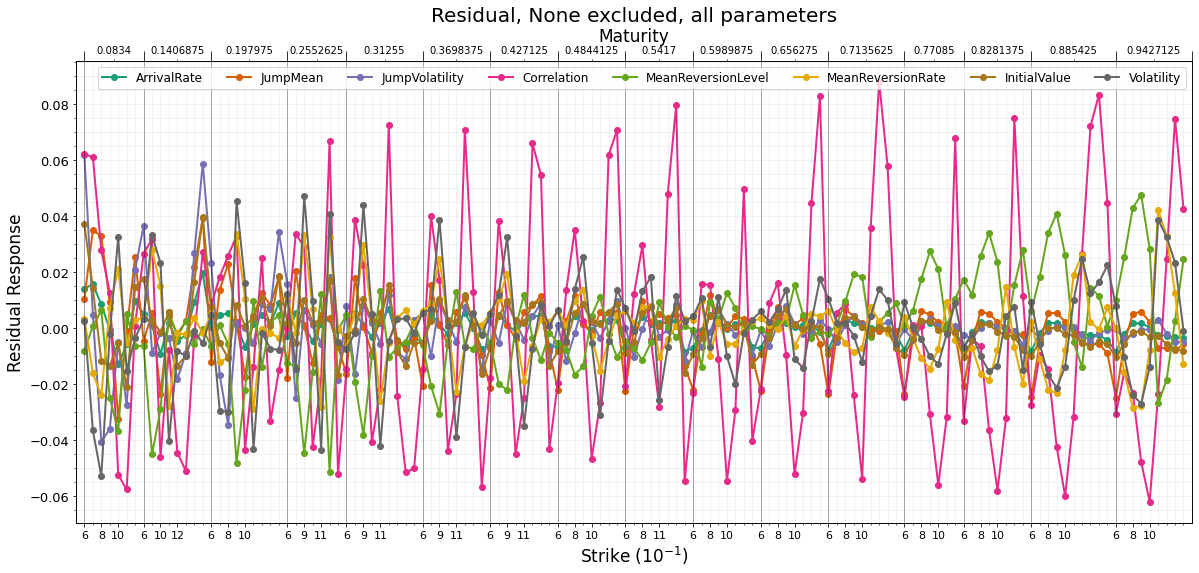

In [60]:
residual_plot_total_automatic(residual=all_residual, exclude=None)


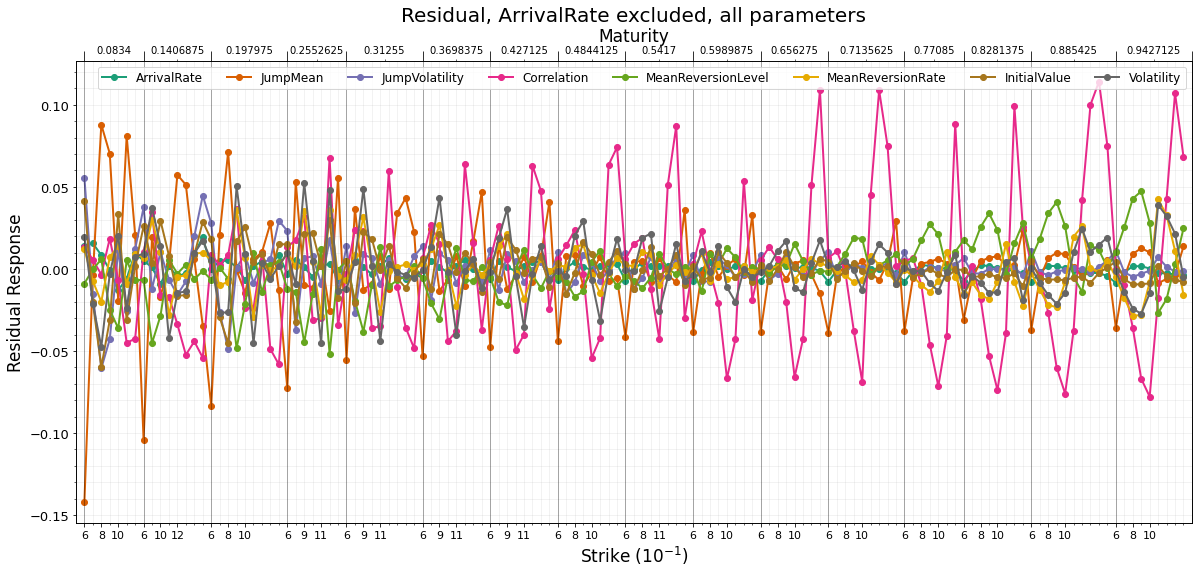

In [62]:
exclude_ArrivalRate_residual_2, exclude_ArrivalRate_norm_2 = Get_Residual_Norm('ArrivalRate')
residual_plot_total_automatic(residual=exclude_ArrivalRate_residual_2, exclude='ArrivalRate')


# Then the codes for Section 2.1 analysis

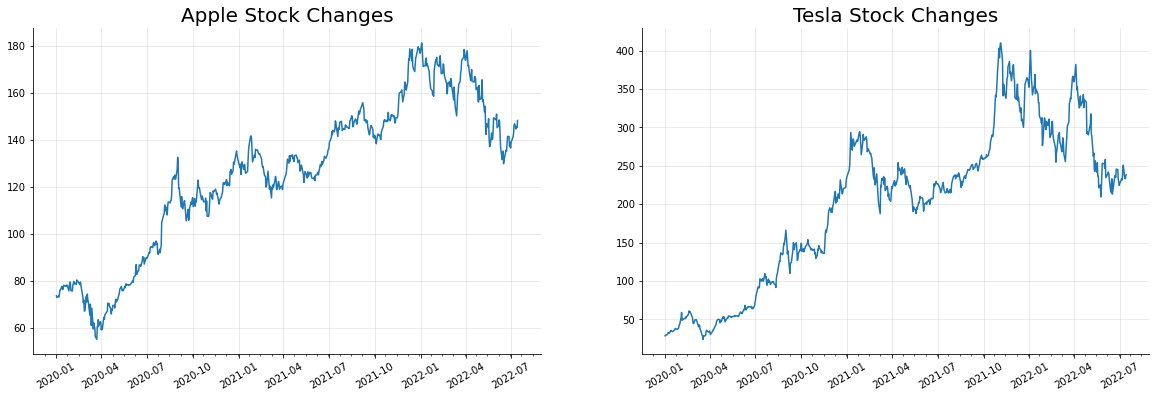

In [63]:
import pandas_datareader as pdr
import datetime as dt
from matplotlib.ticker import (AutoLocator, AutoMinorLocator)

#Apple
ticker_Apple = "AAPL"
start_Apple = dt.datetime(2020, 1, 1)
end_Apple = dt.datetime(2022, 7, 14)
 
data_Apple = pdr.get_data_yahoo(ticker_Apple, start_Apple, end_Apple)
S_Apple = data_Apple.loc[:, 'Adj Close']
temp_df = pd.DataFrame(S_Apple).reset_index()

#Tesla
ticker_Tesla = 'TSLA'
start_Tesla = dt.datetime(2020, 1, 1)
end_Tesla = dt.datetime(2022, 7, 14)

data_Tesla = pdr.get_data_yahoo(ticker_Tesla, start_Tesla, end_Tesla)
S_Tesla = data_Tesla.loc[:, 'Adj Close']
temp_df_tesla = pd.DataFrame(S_Tesla).reset_index()

#Eon
ticker_Eon = 'EONGY'
start_Eon = dt.datetime(2020, 1, 1)
end_Eon = dt.datetime(2022, 7, 14)

data_Eon = pdr.get_data_yahoo(ticker_Eon, start_Eon, end_Eon)
S_Eon = data_Eon.loc[:, 'Adj Close']
temp_df_Eon = pd.DataFrame(S_Eon).reset_index()


fig, ax = plt.subplots(1,2, figsize = (20,6))
ax[0].plot(temp_df['Date'], temp_df['Adj Close'], c='#1f77b4')
ax[0].set_title('Apple Stock Changes', fontsize=20)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(axis="x", which="both", rotation=30)
ax[0].spines.right.set_visible(False)
ax[0].spines.top.set_visible(False)
ax[0].grid(alpha=0.3)

ax[1].plot(temp_df_tesla['Date'], temp_df_tesla['Adj Close'], c='#1f77b4')
ax[1].set_title('Tesla Stock Changes', fontsize=20)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(axis="x", which="both", rotation=30)
ax[1].spines.right.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].grid(alpha=0.3)


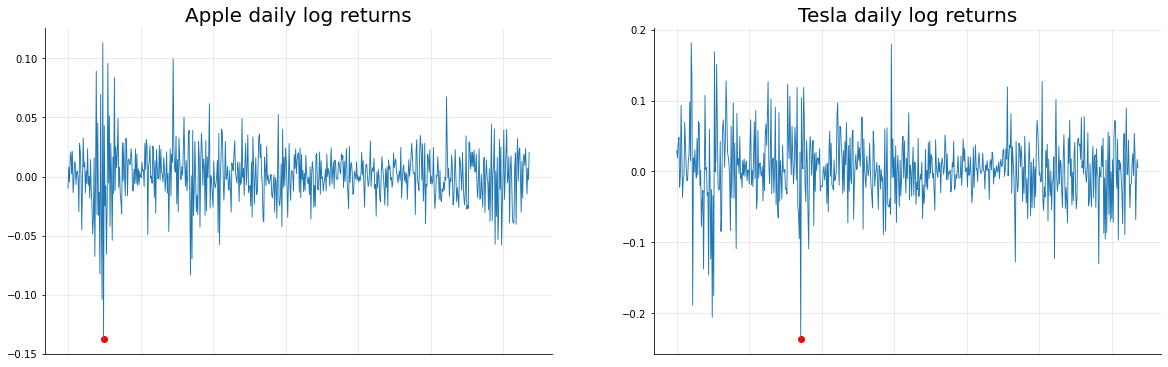

In [64]:
# preparing the data that we use to get the log return
# Apple
S_1_Apple = S_Apple[0:S_Apple.shape[0]-1].values.copy()
S_2_Apple = S_Apple[1:S_Apple.shape[0]].values.copy()
log_return_Apple = np.log(S_2_Apple/S_1_Apple)

df = pd.DataFrame(np.zeros((len(log_return_Apple),2)))
df[0] = log_return_Apple
df[0] = df[0].fillna(value=0)

# Tesla
S_1_T = S_Tesla[0:S_Tesla.shape[0]-1].values.copy()
S_2_T = S_Tesla[1:S_Tesla.shape[0]].values.copy()
log_return_T = np.log(S_2_T/S_1_T)

df_T = pd.DataFrame(np.zeros((len(log_return_T),2)))
df_T[0] = log_return_T
df_T[0] = df_T[0].fillna(value=0)


fig, ax = plt.subplots(1,2, figsize = (20,6))

ax[0].plot(df[0], linewidth = 0.9, c='#1f77b4')
ax[0].scatter(49, df[0].min(), c='r')
ax[0].tick_params(axis='x', bottom=False, labelbottom=False)
ax[0].set_title('Apple daily log returns', fontsize=20)
ax[0].spines.right.set_visible(False)
ax[0].spines.top.set_visible(False)
ax[0].grid(alpha=0.3)

ax[1].plot(df_T[0], linewidth = 0.9, c='#1f77b4')
ax[1].scatter(171, df_T[0].min(), c='r')
ax[1].tick_params(axis='x', bottom=False, labelbottom=False)
ax[1].set_title('Tesla daily log returns', fontsize=20)
ax[1].spines.right.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].grid(alpha=0.3)


# log_return
plt.show()

C:\Users\Roger Cai\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\Roger Cai\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


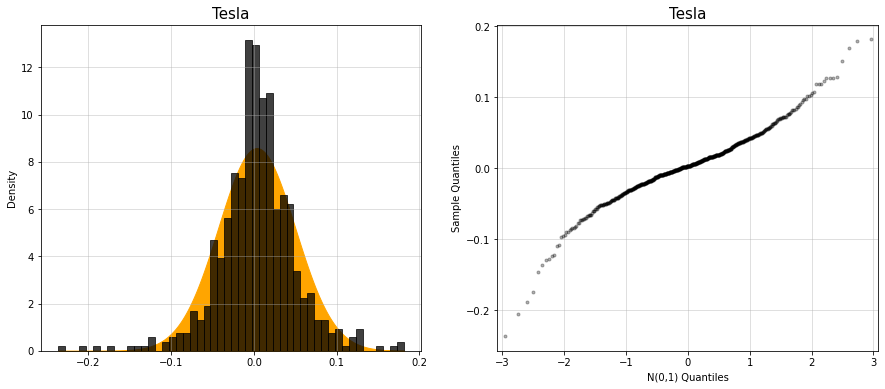

In [66]:
from scipy.stats import norm
import statsmodels.api as sm

x = np.linspace(min(log_return_Apple), max(log_return_Apple), len(log_return_Apple))
normal = norm.pdf(x, loc=log_return_Apple.mean(), scale=log_return_Apple.std())

fig, ax = plt.subplots(1,2, figsize=(15,6))

x_ = np.linspace(min(log_return_T), max(log_return_T), len(log_return_T))
normal_ = norm.pdf(x_, loc=log_return_T.mean(), scale=log_return_T.std())

sns.histplot(log_return_T, bins=50, color='k'
             , stat = 'density', ax=ax[0])
ax[0].fill_between(x_, 0, normal_, color='orange')
ax[0].grid(alpha=0.5)
ax[0].set_title('Tesla', fontsize=15)

qq_ = sm.qqplot(log_return_T, c='b', ax=ax[1], marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.3)
ax[1].grid(alpha=0.5)
ax[1].set_title('Tesla', fontsize=15)
ax[1].set_xlabel('N(0,1) Quantiles')


plt.show()
